# YanuX Skeletron User Study

## Imports

In [144]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.decomposition import PCA
from datetime import datetime, date, time

## Helper Functions

In [145]:
def print_stats(data, hist_bins=None, plt_size=(8,6)):
    results = {
        'describe': data.describe(),
        'value_counts': data.value_counts()
    }
    
    print('--- Statistics ----')
    display(results['describe'])
    print('\n')
    
    print('--- Counting Unique Values ----')
    display(results['value_counts'])
    print('\n')
    
    if hist_bins is None:
        print('--- Basic Bar Chart ----')
        results['value_counts'].sort_index().plot(kind='bar', figsize=plt_size)
    else:
        print('--- Basic Histogram ----')
        data.hist(bins=hist_bins, figsize=plt_size)
    
    plt.show()
    
    return results
    
def calculate_sus(data):
    for i in range(len(data.columns)):
        if i % 2:
            data.iloc[:,i] = 7 - data.iloc[:,i]
        else:
            data.iloc[:,i] = data.iloc[:,i] - 1

    data['SUS Score'] = data.iloc[:,0:10].sum(axis=1)
    data['SUS Score 100'] = data['SUS Score'] * (100/60)
    return data

def confidence_interval_t(data, confidence_level=0.95):
    return stats.t.interval(confidence_level, data.count()-1, data.mean(), data.sem())

def convert_time_to_timedelta(value):
    return datetime.combine(date.min, value) - datetime.min

def kendall_pval(x,y):
    return stats.kendalltau(x,y)[1]

def pearsonr_pval(x,y):
    return stats.pearsonr(x,y)[1]

def spearmanr_pval(x,y):
    return stats.spearmanr(x,y)[1]

def normality_tests(data, alpha=0.05, shapiro=True, dagostino=False, anderson=False):
    if shapiro is True:
        print('Shapiro-Wilk Test')
        stat, p =  stats.shapiro(data)
        print('Statistics=%.3f, p=%.3f' % (stat, p))
        if p > alpha:
            print('Sample looks Gaussian (fail to reject H0)')
        else:
            print('Sample does not look Gaussian (reject H0)')

    if dagostino is True:
        print('D\'Agostino’s K^2 Test')
        stat, p = stats.normaltest(data)
        print('Statistics=%.3f, p=%.3f' % (stat, p))
        if p > alpha:
            print('Sample looks Gaussian (fail to reject H0)')
        else:
            print('Sample does not look Gaussian (reject H0)')

    if anderson is True:
        print('Anderson-Darling Test')
        result = stats.anderson(data)
        p = 0
        for i in range(len(result.critical_values)):
            sl, cv = result.significance_level[i], result.critical_values[i]
            if result.statistic < result.critical_values[i]:
                print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
            else:
                print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

def biplot(score, coeff , y):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    plt.figure(figsize=(8,6), dpi=100)
    classes = np.unique(y)
    colors = ['g','r','y']
    markers=['o','^','x']
    for s,l in enumerate(classes):
        plt.scatter(xs[y==l],ys[y==l], c = colors[s], marker=markers[s]) # color based on group
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1], color = 'k', alpha = 0.9,linestyle = '-',linewidth = 1.5, overhang=0.2)
        plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'k', ha = 'center', va = 'center',fontsize=10)
    plt.xlabel("PC{}".format(1), size=14)
    plt.ylabel("PC{}".format(2), size=14)
    limx= int(xs.max()) + 1
    limy= int(ys.max()) + 1
    plt.xlim([-limx,limx])
    plt.ylim([-limy,limy])
    plt.grid()
    plt.tick_params(axis='both', which='both', labelsize=14)

def statistical_significance_highlight(v):
    if v < 0.05:
        return 'color: red;'
    elif v < 0.1:
        return 'color: yellow;'
    else:
        return None

def calculate_correlation(data, pearson=False, spearman=False, kendall=True):
    results = {
        'Pearson\'s Correlation': data.corr(method='pearson'),
        'Pearson\'s Correlation p-value': data.corr(method=pearsonr_pval).style.applymap(statistical_significance_highlight),
        'Spearman\'s Correlation': data.corr(method='spearman'),
        'Spearman\'s Correlation p-value': data.corr(method=spearmanr_pval).style.applymap(statistical_significance_highlight),
        'Kendall\'s Correlation': data.corr(method='kendall'),
        'Kendall\'s Correlation p-value': data.corr(method=kendall_pval).style.applymap(statistical_significance_highlight)
    }
    
    if pearson is True:
        print('Pearson\'s Correlation')
        display(results['Pearson\'s Correlation'])
        display(results['Pearson\'s Correlation p-value'])
    
    if spearman is True:
        print('Spearman\'s Correlation')
        display(results['Spearman\'s Correlation'])
        display(results['Spearman\'s Correlation p-value'])
    
    if kendall is True:
        print('Kendall Correlation')
        display(results['Kendall\'s Correlation'])
        display(results['Kendall\'s Correlation p-value'])
    
    return results

## Load Excel

In [146]:
data = pd.read_excel('data/userstudies/yanux-skeletron-data.xlsx', sheet_name=None)  

## Demographics

In [147]:
data_demographics = data['Demographics']
data_demographics

,Age,Gender,Education,Education Area,Devices Owned,Usage of Multiple Devices
0,52,Male,Master's Degree,Computer Science,"Desktop computer, Laptop computer, Smartphone",7
1,23,Female,Bachelor's Degree,Computer Science,"Laptop computer, Smartphone",5
2,24,Female,Bachelor's Degree,Computer Science,"Desktop computer, Laptop computer, Smartphone,...",6
3,22,Male,Bachelor's Degree,Computer Science,"Laptop computer, Smartphone, Smart TV",3
4,22,Male,Post-Secondary Education,Computer Science,"Desktop computer, Laptop computer, Smartphone",6
5,24,Female,Bachelor's Degree,Computer Science,"Laptop computer, Smartphone, Tablet, Smartwatc...",5
6,35,Male,Master's Degree,Computer Science,"Desktop computer, Laptop computer, Smartphone,...",7
7,25,Male,Bachelor's Degree,Computer Science,"Laptop computer, Smartphone, Tablet, Smart TV,...",5
8,29,Female,Secondary Education,Computer Science,"Desktop computer, Laptop computer, Smartphone,...",7
9,25,Male,Bachelor's Degree,Computer Science,"Desktop computer, Laptop computer, Smartphone,...",6


### Age

--- Statistics ----


count    21.00000
mean     26.52381
std       7.22924
min      20.00000
25%      23.00000
50%      24.00000
75%      26.00000
max      52.00000
Name: Age, dtype: float64



--- Counting Unique Values ----


24    4
25    4
23    3
22    2
52    1
35    1
29    1
20    1
27    1
38    1
26    1
21    1
Name: Age, dtype: int64



--- Basic Histogram ----


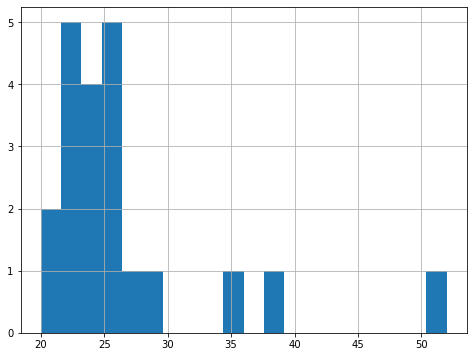

Population Standard Deviation:
7.0550154238233596
Confidence Interval (95%):
(23.23309912455611, 29.814519923062942)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.679, p=0.000
Sample does not look Gaussian (reject H0)


In [148]:
data_demographics_age = data_demographics['Age']
print_stats(data_demographics_age, hist_bins=20)
print('Population Standard Deviation:')
print(data_demographics_age.std(ddof=0))
print('Confidence Interval (95%):')
print(confidence_interval_t(data_demographics_age))
print('Normality Tests:')
normality_tests(data_demographics_age)

### Gender

--- Statistics ----


count       21
unique       2
top       Male
freq        17
Name: Gender, dtype: object



--- Counting Unique Values ----


Male      17
Female     4
Name: Gender, dtype: int64



--- Basic Bar Chart ----


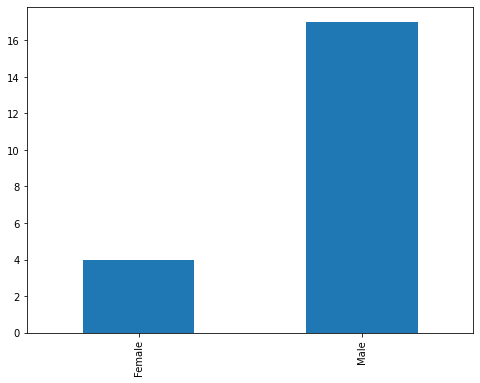

In [149]:
data_demographics_genre = data_demographics['Gender']
print_stats(data_demographics_genre);

### Education

--- Statistics ----


count                    21
unique                    5
top       Bachelor's Degree
freq                     14
Name: Education, dtype: object



--- Counting Unique Values ----


Bachelor's Degree           14
Master's Degree              3
Secondary Education          2
Post-Secondary Education     1
Doctoral Degree              1
Name: Education, dtype: int64



--- Basic Bar Chart ----


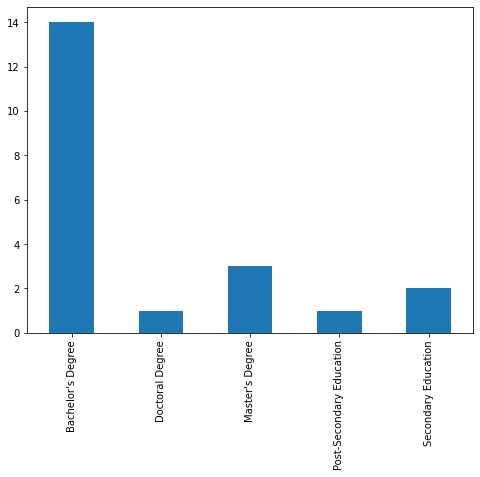

In [150]:
data_demographics_education = data_demographics['Education']
print_stats(data_demographics_education);

### Education Area

--- Statistics ----


count                   21
unique                   2
top       Computer Science
freq                    20
Name: Education Area, dtype: object



--- Counting Unique Values ----


Computer Science            20
Electrical Engineering\n     1
Name: Education Area, dtype: int64



--- Basic Bar Chart ----


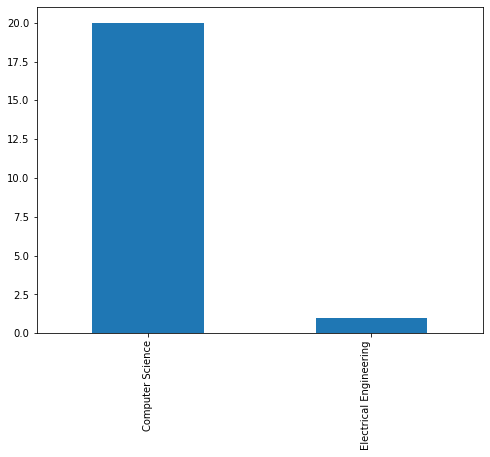

In [151]:
data_demographics_education_area = data_demographics['Education Area']
print_stats(data_demographics_education_area);

### Devices Owned

In [152]:
data_demographics_devices_owned = data_demographics['Devices Owned']
data_demographics_devices_owned_list = data_demographics_devices_owned.map(lambda x: [i.strip() for i in x.split(",")])

print('--- Statistics ----')
display(data_demographics_devices_owned_list.describe())
print('--- Counting Unique Values ----')
display(data_demographics_devices_owned.value_counts())

--- Statistics ----


count                                                  21
unique                                                 16
top       [Desktop computer, Laptop computer, Smartphone]
freq                                                    3
Name: Devices Owned, dtype: object

--- Counting Unique Values ----


Desktop computer, Laptop computer, Smartphone                                                                  3
Laptop computer, Smartphone, Smart TV                                                                          3
Laptop computer, Smartphone                                                                                    2
Desktop computer, Laptop computer, Smartphone, Tablet, Smart TV, Smartwatch                                    1
Laptop computer, Smartphone, Tablet, Smartwatch, Smart speaker                                                 1
Desktop computer, Laptop computer, Smartphone, Tablet, Smart TV, Smartwatch, Fitness tracker                   1
Laptop computer, Smartphone, Tablet, Smart TV, Fitness tracker                                                 1
Desktop computer, Laptop computer, Smartphone, Tablet, Fitness tracker                                         1
Desktop computer, Laptop computer, Smartphone, Smart TV                                         

#### Number of Devices Owned

In [153]:
mlb_devices_owned = MultiLabelBinarizer()
devices_owned_one_hot = pd.DataFrame(mlb_devices_owned.fit_transform(data_demographics_devices_owned_list),
                                     columns=mlb_devices_owned.classes_,index=data_demographics_devices_owned_list.index)
devices_owned_one_hot

,Desktop computer,Fitness tracker,Laptop computer,Smart TV,Smart speaker,Smartphone,Smartwatch,Tablet
0,1,0,1,0,0,1,0,0
1,0,0,1,0,0,1,0,0
2,1,0,1,1,0,1,1,1
3,0,0,1,1,0,1,0,0
4,1,0,1,0,0,1,0,0
5,0,0,1,0,1,1,1,1
6,1,1,1,1,0,1,1,1
7,0,1,1,1,0,1,0,1
8,1,1,1,0,0,1,0,1
9,1,0,1,1,0,1,0,0


In [154]:
num_devices_owned = devices_owned_one_hot.sum(axis=1)
num_devices_owned

0     3
1     2
2     6
3     3
4     3
5     5
6     7
7     5
8     5
9     4
10    4
11    4
12    3
13    3
14    8
15    3
16    5
17    2
18    3
19    3
20    5
dtype: int64

--- Statistics ----


count    21.000000
mean      4.095238
std       1.578124
min       2.000000
25%       3.000000
50%       4.000000
75%       5.000000
max       8.000000
dtype: float64



--- Counting Unique Values ----


3    8
5    5
4    3
2    2
6    1
7    1
8    1
dtype: int64



--- Basic Bar Chart ----


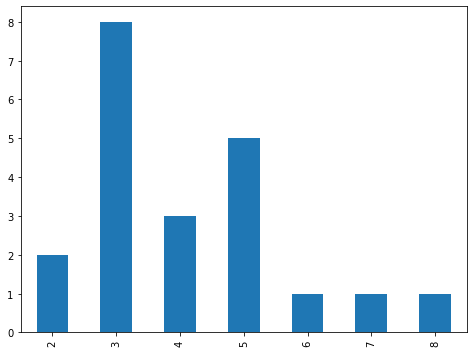

Population Standard Deviation:
1.540091583694879
Confidence Interval (95%):
(3.3768845430752172, 4.813591647400973)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.891, p=0.024
Sample does not look Gaussian (reject H0)


In [155]:
print_stats(num_devices_owned)
print('Population Standard Deviation:')
print(num_devices_owned.std(ddof=0))
print('Confidence Interval (95%):')
print(confidence_interval_t(num_devices_owned))
print('Normality Tests:')
normality_tests(num_devices_owned)

##### Device Types Owned

In [156]:
device_types_owned = devices_owned_one_hot.sum().sort_values(ascending=False)
device_types_owned

Smartphone          21
Laptop computer     20
Desktop computer    12
Smart TV            11
Tablet               8
Smartwatch           7
Fitness tracker      5
Smart speaker        2
dtype: int64

<AxesSubplot:>

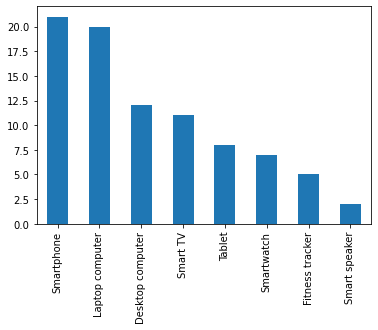

In [157]:
device_types_owned.plot(kind='bar')

##### Percentage of Participants that Own Each Type of Device

In [158]:
(devices_owned_one_hot.sum()/devices_owned_one_hot.count()*100).sort_values(ascending=False)

Smartphone          100.000000
Laptop computer      95.238095
Desktop computer     57.142857
Smart TV             52.380952
Tablet               38.095238
Smartwatch           33.333333
Fitness tracker      23.809524
Smart speaker         9.523810
dtype: float64

### Usage of Multiple Devices

--- Statistics ----


count    21.000000
mean      5.761905
std       1.445848
min       2.000000
25%       5.000000
50%       6.000000
75%       7.000000
max       7.000000
Name: Usage of Multiple Devices, dtype: float64



--- Counting Unique Values ----


7    9
5    5
6    4
3    1
2    1
4    1
Name: Usage of Multiple Devices, dtype: int64



--- Basic Bar Chart ----


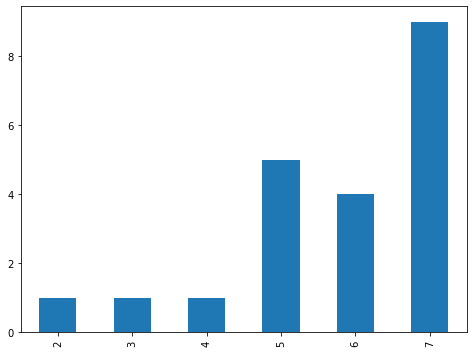

Population Standard Deviation:
1.4110030847646717
Confidence Interval (95%):
(5.103762682054079, 6.420046841755445)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.819, p=0.001
Sample does not look Gaussian (reject H0)


In [159]:
data_demographics_usage_multiple_devices = data_demographics['Usage of Multiple Devices']
print_stats(data_demographics_usage_multiple_devices)
print('Population Standard Deviation:')
print(data_demographics_usage_multiple_devices.std(ddof=0))
print('Confidence Interval (95%):')
print(confidence_interval_t(data_demographics_usage_multiple_devices))
print('Normality Tests:')
normality_tests(data_demographics_usage_multiple_devices)

#### Percentage of Users that User Multiple Devices Sometimes or More Often

In [160]:
(data_demographics_usage_multiple_devices[data_demographics_usage_multiple_devices >= 5].count()/data_demographics_usage_multiple_devices.count())*100

85.71428571428571

## Programming Experience

In [161]:
data_programming_experience = data['Programming Experience']
data_programming_experience

,Years of Programming Experience,Programming Experience (Self Assessment),JavaScript Experience (Self Assessment),Experience with Programming Languages
0,30,6,6,"C, C++, C#, Delphi/Pascal, Java, Perl, PHP, Py..."
1,5,6,6,"C#, Dart, Java, Kotlin, Matlab, PHP, TypeScript"
2,6,4,4,"C++, C#, Java, Kotlin"
3,5,6,5,"C, C++, Java, Python, Ruby"
4,7,5,5,"C, C#, Dart, Java, Matlab, PHP, Python, R, Vis..."
5,5,4,4,"C, C#, Java, Python"
6,20,7,7,"C, C#, Java, PHP, Python, Visual Basic/Visual ..."
7,6,5,5,"C, C#, Dart, Java, Python, TypeScript"
8,4,3,3,"C, C++, C#, Java, Python, Visual Basic/Visual ..."
9,6,5,5,"C, C#, Java, Kotlin, Matlab, PHP, Python"


### Years of Programming Experience

--- Statistics ----


count    21.000000
mean      8.714286
std       6.914787
min       3.000000
25%       5.000000
50%       7.000000
75%       8.000000
max      30.000000
Name: Years of Programming Experience, dtype: float64



--- Counting Unique Values ----


6     4
7     4
5     3
8     3
3     2
30    1
20    1
4     1
9     1
23    1
Name: Years of Programming Experience, dtype: int64



--- Basic Histogram ----


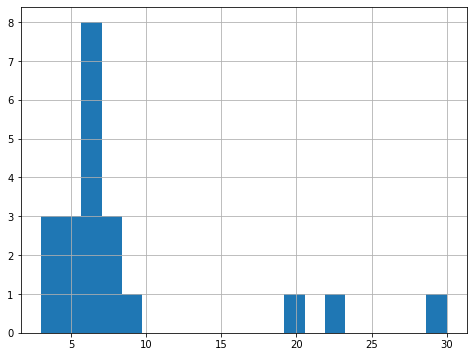

Population Standard Deviation:
6.748141593504569
Confidence Interval (95%):
(5.566712196247153, 11.861859232324274)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.666, p=0.000
Sample does not look Gaussian (reject H0)


In [162]:
data_programming_experience_years = data_programming_experience['Years of Programming Experience']
print_stats(data_programming_experience_years, hist_bins=20)
print('Population Standard Deviation:')
print(data_programming_experience_years.std(ddof=0))
print('Confidence Interval (95%):')
print(confidence_interval_t(data_programming_experience_years))
print('Normality Tests:')
normality_tests(data_programming_experience_years)

### Programming Experience (Self Assessment)

--- Statistics ----


count    21.000000
mean      5.285714
std       1.146423
min       3.000000
25%       4.000000
50%       5.000000
75%       6.000000
max       7.000000
Name: Programming Experience (Self Assessment), dtype: float64



--- Counting Unique Values ----


6    7
4    5
5    5
7    3
3    1
Name: Programming Experience (Self Assessment), dtype: int64



--- Basic Bar Chart ----


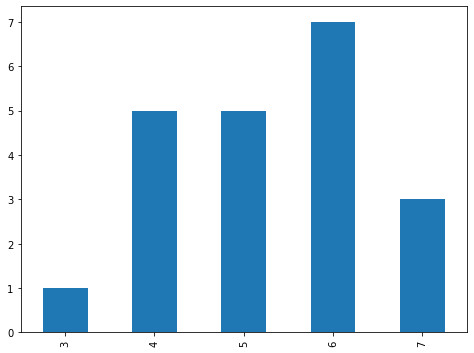

Population Standard Deviation:
1.1187942975686411
Confidence Interval (95%):
(4.763868788792701, 5.80755978263587)


In [163]:
data_programming_experience_self = data_programming_experience['Programming Experience (Self Assessment)']
print_stats(data_programming_experience_self)
print('Population Standard Deviation:')
print(data_programming_experience_self.std(ddof=0))
print('Confidence Interval (95%):')
print(confidence_interval_t(data_programming_experience_self))

### JavaScript Experience (Self Assessment)

--- Statistics ----


count    21.000000
mean      4.571429
std       1.362770
min       1.000000
25%       4.000000
50%       5.000000
75%       5.000000
max       7.000000
Name: JavaScript Experience (Self Assessment), dtype: float64



--- Counting Unique Values ----


5    7
4    5
6    4
3    3
7    1
1    1
Name: JavaScript Experience (Self Assessment), dtype: int64



--- Basic Bar Chart ----


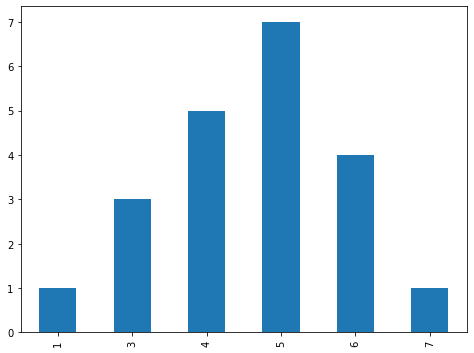

Population Standard Deviation:
1.3299276232160895
Confidence Interval (95%):
(3.951102973671077, 5.191754169186065)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.931, p=0.144
Sample looks Gaussian (fail to reject H0)


In [164]:
data_programming_experience_javascript = data_programming_experience['JavaScript Experience (Self Assessment)']
print_stats(data_programming_experience_javascript)
print('Population Standard Deviation:')
print(data_programming_experience_javascript.std(ddof=0))
print('Confidence Interval (95%):')
print(confidence_interval_t(data_programming_experience_javascript))
print('Normality Tests:')
normality_tests(data_programming_experience_javascript)

### Experience with Programming Languages

In [165]:
data_programming_experience_languages = data_programming_experience['Experience with Programming Languages']
data_programming_experience_languages_list = data_programming_experience_languages.map(lambda x: [i.strip() for i in x.split(",")])

#### Programming Languages

In [166]:
mlb_programming_languages = MultiLabelBinarizer()
programming_languages_one_hot = pd.DataFrame(mlb_programming_languages.fit_transform(data_programming_experience_languages_list),
                                             columns=mlb_programming_languages.classes_,index=data_programming_experience_languages_list.index)
programming_languages_one_hot

,C,C#,C++,Dart,Delphi/Pascal,Java,Kotlin,Matlab,PHP,Perl,Python,R,Ruby,Swift,TypeScript,Visual Basic/Visual Basic for Applications
0,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,1
1,0,1,0,1,0,1,1,1,1,0,0,0,0,0,1,0
2,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0
3,1,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0
4,1,1,0,1,0,1,0,1,1,0,1,1,0,0,0,1
5,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0
6,1,1,0,0,0,1,0,0,1,0,1,0,0,0,0,1
7,1,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0
8,1,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1
9,1,1,0,0,0,1,1,1,1,0,1,0,0,0,0,0


In [167]:
num_programming_languages = programming_languages_one_hot.sum(axis=1)
num_programming_languages

0      9
1      7
2      4
3      5
4      9
5      4
6      6
7      6
8      6
9      7
10    11
11    12
12     2
13     5
14     6
15     1
16     7
17     7
18     3
19     6
20     4
dtype: int64

--- Statistics ----


count    21.000000
mean      6.047619
std       2.710649
min       1.000000
25%       4.000000
50%       6.000000
75%       7.000000
max      12.000000
dtype: float64



--- Counting Unique Values ----


6     5
7     4
4     3
9     2
5     2
11    1
12    1
2     1
1     1
3     1
dtype: int64



--- Basic Bar Chart ----


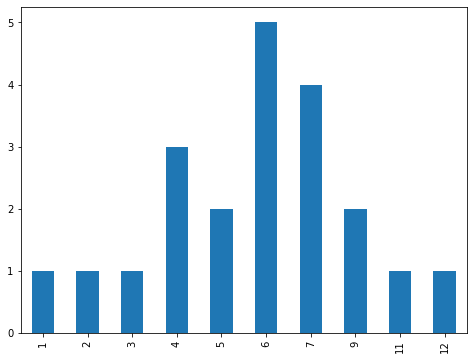

Population Standard Deviation:
2.645322745205933
Confidence Interval (95%):
(4.813746328129907, 7.281491767108188)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.964, p=0.607
Sample looks Gaussian (fail to reject H0)


In [168]:
print_stats(num_programming_languages)
print('Population Standard Deviation:')
print(num_programming_languages.std(ddof=0))
print('Confidence Interval (95%):')
print(confidence_interval_t(num_programming_languages))
print('Normality Tests:')
normality_tests(num_programming_languages)

##### How Many Participants Know Each Programming Language

In [169]:
participants_programming_language = programming_languages_one_hot.sum().sort_values(ascending=False)
participants_programming_language

Java                                          20
C#                                            17
C                                             16
Python                                        16
PHP                                           10
C++                                            9
TypeScript                                     8
Kotlin                                         7
Dart                                           6
Matlab                                         6
Visual Basic/Visual Basic for Applications     6
Ruby                                           2
Delphi/Pascal                                  1
Perl                                           1
R                                              1
Swift                                          1
dtype: int64

<AxesSubplot:>

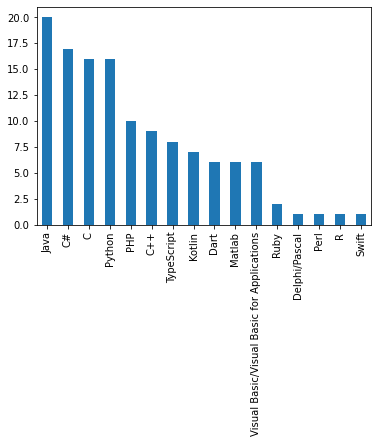

In [170]:
participants_programming_language.plot(kind='bar')

##### Percentage of Participants that Know Each Programming Language

In [171]:
(programming_languages_one_hot.sum()/programming_languages_one_hot.count()*100).sort_values(ascending=False)

Java                                          95.238095
C#                                            80.952381
C                                             76.190476
Python                                        76.190476
PHP                                           47.619048
C++                                           42.857143
TypeScript                                    38.095238
Kotlin                                        33.333333
Dart                                          28.571429
Matlab                                        28.571429
Visual Basic/Visual Basic for Applications    28.571429
Ruby                                           9.523810
Delphi/Pascal                                  4.761905
Perl                                           4.761905
R                                              4.761905
Swift                                          4.761905
dtype: float64

## Domain Specific Questions

- **DS1:** It makes sense that the UI state of an application is represented by an object.
- **DS2:** I understood how to save the UI state of an application every time it changes.
- **DS3:** I understood how to use the "Coordinator" API to perform various tasks that make my multi-device application behave properly?
- **DS4:** I understood how the DSL (Domain Specific Language) for the automatic distribution of UI components works.
- **DS5:** I understood how to use the "ComponentsRuleEngine" to determine the appropriate distribution of UI components based on the restrictions placed on them and the proxemics relationships between devices currently running application instances.
- **DS6:** I understood how the custom "YanuX Resource Management Element" can be used to manage multiple application states of an application.
- **DS7:** I understood how the custom "YanuX Components Distribution Element" can be used to manage the distribution of UI components of an application.	
- **DS8:** It makes sense to distribute the UI components of an application depending on how closely related the surrounding devices are.

In [172]:
data_domain_specific = data['Domain Specific']
data_domain_specific

,DS1,DS2,DS3,DS4,DS5,DS6,DS7,DS8
0,7,7,7,7,7,7,7,7
1,7,6,6,6,5,6,6,5
2,5,7,6,6,6,6,6,7
3,7,6,6,6,6,6,6,7
4,6,6,6,6,6,6,6,6
5,7,6,6,5,5,6,5,6
6,7,6,7,7,7,7,6,7
7,7,7,7,7,6,6,7,6
8,7,6,6,5,7,7,6,7
9,6,7,6,6,5,5,5,6


--- Statistics ----


,DS1,DS2,DS3,DS4,DS5,DS6,DS7,DS8
count,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
mean,6.428571,6.000000,6.142857,5.476190,5.571429,6.000000,6.000000,6.571429
std,0.870140,1.414214,0.654654,1.077917,0.925820,1.095445,0.774597,0.597614
min,4.000000,2.000000,5.000000,3.000000,4.000000,2.000000,4.000000,5.000000
25%,6.000000,6.000000,6.000000,5.000000,5.000000,6.000000,6.000000,6.000000
50%,7.000000,6.000000,6.000000,6.000000,5.000000,6.000000,6.000000,7.000000
75%,7.000000,7.000000,7.000000,6.000000,6.000000,7.000000,6.000000,7.000000
max,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000




--- Counting Unique Values ----


DS1  DS2  DS3  DS4  DS5  DS6  DS7  DS8
4    2    5    5    4    2    4    7      1
7    6    6    5    7    7    6    7      1
     7    7    7    6    6    7    6      1
               5    5    6    6    7      1
          6    5    6    6    6    7      1
     6    7    7    7    7    6    7      1
               3    7    7    7    7      1
          6    6    6    6    6    7      1
                    5    7    6    7      1
                         6    6    5      1
               5    5    6    5    7      1
5    6    5    3    5    6    6    6      1
7    6    6    5    5    6    5    6      1
     2    5    6    4    5    6    6      1
6    7    6    6    5    6    6    7      1
                         5    5    6      1
               5    6    7    7    6      1
     6    7    5    5    6    7    7      1
          6    6    6    6    6    6      1
5    7    6    6    6    6    6    7      1
7    7    7    7    7    7    7    7      1
dtype: int64



--- Basic Histogram ----


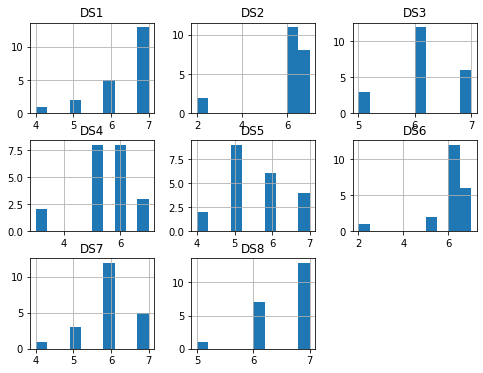

---- Question DS1 ----
Population Standard Deviation:
0.84916926191081
Confidence Interval (95%):
(6.032488648729413, 6.8246542084134445)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.702, p=0.000
Sample does not look Gaussian (reject H0)


---- Question DS2 ----
Population Standard Deviation:
1.3801311186847085
Confidence Interval (95%):
(5.356257704376816, 6.643742295623184)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.599, p=0.000
Sample does not look Gaussian (reject H0)


---- Question DS3 ----
Population Standard Deviation:
0.6388765649999398
Confidence Interval (95%):
(5.84486236467631, 6.440851921037977)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.792, p=0.000
Sample does not look Gaussian (reject H0)


---- Question DS4 ----
Population Standard Deviation:
1.051939144494025
Confidence Interval (95%):
(4.98552860315204, 5.966852349228913)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.850, p=0.004
Sample does not look Gaussian (reject H0)


---- Question DS5 ----
Popul

In [173]:
print_stats(data_domain_specific, hist_bins=10)

for column in data_domain_specific:
    print('---- Question', column,'----')
    print('Population Standard Deviation:')
    print(data_domain_specific[column].std(ddof=0))
    print('Confidence Interval (95%):')
    print(confidence_interval_t(data_domain_specific[column]))
    print('Normality Tests:')
    normality_tests(data_domain_specific[column])
    print('\n')

### Response Frequency

In [174]:
data_domain_specific_freq = (data_domain_specific.apply(pd.value_counts).fillna(0)/data_domain_specific.count()*100).transpose()
data_domain_specific_freq

,2,3,4,5,6,7
DS1,0.000000,0.00000,4.761905,9.523810,23.809524,61.904762
DS2,9.523810,0.00000,0.000000,0.000000,52.380952,38.095238
DS3,0.000000,0.00000,0.000000,14.285714,57.142857,28.571429
DS4,0.000000,9.52381,0.000000,38.095238,38.095238,14.285714
DS5,0.000000,0.00000,9.523810,42.857143,28.571429,19.047619
DS6,4.761905,0.00000,0.000000,9.523810,57.142857,28.571429
DS7,0.000000,0.00000,4.761905,14.285714,57.142857,23.809524
DS8,0.000000,0.00000,0.000000,4.761905,33.333333,61.904762


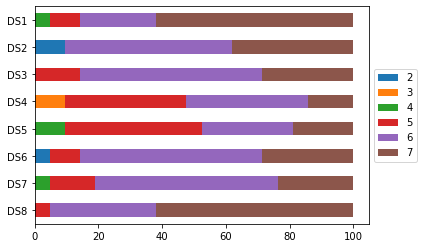

In [175]:
data_domain_specific_freq.iloc[::-1].plot.barh(stacked=True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

### Correlation

In [176]:
calculate_correlation(data_domain_specific);

Kendall Correlation


,DS1,DS2,DS3,DS4,DS5,DS6,DS7,DS8
DS1,1.000000,-0.056692,0.388744,0.178145,0.265453,0.353553,0.135027,0.094916
DS2,-0.056692,1.000000,0.396825,0.203670,0.310714,0.157485,0.303559,0.050735
DS3,0.388744,0.396825,1.000000,0.225492,0.520266,0.480330,0.544850,0.295952
DS4,0.178145,0.203670,0.225492,1.000000,0.178812,0.021651,0.128408,-0.085248
DS5,0.265453,0.310714,0.520266,0.178812,1.000000,0.695416,0.488981,0.246358
DS6,0.353553,0.157485,0.480330,0.021651,0.695416,1.000000,0.532854,0.276852
DS7,0.135027,0.303559,0.544850,0.128408,0.488981,0.532854,1.000000,0.033171
DS8,0.094916,0.050735,0.295952,-0.085248,0.246358,0.276852,0.033171,1.000000


,DS1,DS2,DS3,DS4,DS5,DS6,DS7,DS8
DS1,1.000000,0.783228,0.057198,0.370159,0.179996,0.081678,0.503286,0.649792
DS2,0.783228,1.000000,0.055358,0.311854,0.121355,0.444012,0.137486,0.810700
DS3,0.057198,0.055358,1.000000,0.259018,0.008930,0.018598,0.007203,0.158949
DS4,0.370159,0.311854,0.259018,1.000000,0.355534,0.913136,0.514903,0.676449
DS5,0.179996,0.121355,0.008930,0.355534,1.000000,0.000435,0.012780,0.225941
DS6,0.081678,0.444012,0.018598,0.913136,0.000435,1.000000,0.008159,0.184692
DS7,0.503286,0.137486,0.007203,0.514903,0.012780,0.008159,1.000000,0.872889
DS8,0.649792,0.810700,0.158949,0.676449,0.225941,0.184692,0.872889,1.000000


## UMUX-Lite
- **ULI1:** The YanuX Framework's capabilities meet my requirements.
- **ULI2:** The YanuX Framework is easy to use.

In [177]:
data_umux_lite = data['UMUX-Lite']
data_umux_lite

,ULI1,ULI2
0,7,7
1,4,6
2,6,6
3,7,7
4,7,6
5,6,7
6,6,7
7,6,7
8,7,5
9,7,6


--- Statistics ----


,ULI1,ULI2
count,21.000000,21.000000
mean,5.952381,5.714286
std,1.023533,0.956183
min,4.000000,4.000000
25%,5.000000,5.000000
50%,6.000000,6.000000
75%,7.000000,6.000000
max,7.000000,7.000000




--- Counting Unique Values ----


ULI1  ULI2
5     5       4
7     6       4
6     7       3
      6       2
7     5       2
      7       2
4     4       1
      6       1
5     4       1
6     5       1
dtype: int64



--- Basic Histogram ----


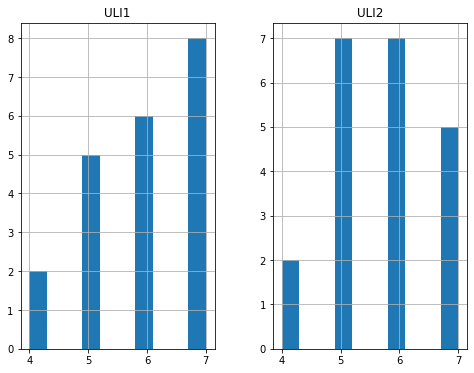

---- Question ULI1 ----
Population Standard Deviation:
0.9988655696858585
Confidence Interval (95%):
(5.486474484406129, 6.418287420355776)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.846, p=0.004
Sample does not look Gaussian (reject H0)


---- Question ULI2 ----
Population Standard Deviation:
0.9331389496316868
Confidence Interval (95%):
(5.279036482210005, 6.149534946361424)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.882, p=0.016
Sample does not look Gaussian (reject H0)




In [178]:
print_stats(data_umux_lite, hist_bins=10)
for column in data_umux_lite:
    print('---- Question', column,'----')
    print('Population Standard Deviation:')
    print(data_umux_lite[column].std(ddof=0))
    print('Confidence Interval (95%):')
    print(confidence_interval_t(data_umux_lite[column]))
    print('Normality Tests:')
    normality_tests(data_umux_lite[column])
    print('\n')

### Response Frequency

In [179]:
data_umux_lite_freq = (data_umux_lite.apply(pd.value_counts).fillna(0)/data_umux_lite.count()*100).transpose()
data_umux_lite_freq

,4,5,6,7
ULI1,9.52381,23.809524,28.571429,38.095238
ULI2,9.52381,33.333333,33.333333,23.809524


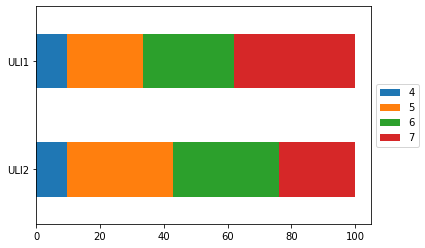

In [180]:
data_umux_lite_freq.iloc[::-1].plot.barh(stacked=True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

### Correlation

In [181]:
calculate_correlation(data_umux_lite);

Kendall Correlation


,ULI1,ULI2
ULI1,1.000000,0.389778
ULI2,0.389778,1.000000


,ULI1,ULI2
ULI1,1.000000,0.041572
ULI2,0.041572,1.000000


### SUS Conversion

In [186]:
data_umux_lite['SUS'] = 0.65 * ((data_umux_lite['ULI1'] + data_umux_lite['ULI2'] - 2) * (100/12))+22.9
data_umux_lite

,ULI1,ULI2,SUS
0,7,7,87.900000
1,4,6,66.233333
2,6,6,77.066667
3,7,7,87.900000
4,7,6,82.483333
5,6,7,82.483333
6,6,7,82.483333
7,6,7,82.483333
8,7,5,77.066667
9,7,6,82.483333


In [187]:
data_umux_lite['SUS'].describe()

count    21.000000
mean     75.261111
std       9.277112
min      55.400000
25%      66.233333
50%      77.066667
75%      82.483333
max      87.900000
Name: SUS, dtype: float64

## Semantic Differential Scales
- **SDS1:** Uninteresting/Interesting
- **SDS2:** Complex/Simple
- **SDS3:** Inappropriate/Appropriate
- **SDS4:** Hard to Understand/Easy to Understand
- **SDS5:** Hard to Learn/Easy to Learn
- **SDS6:** Hard to Develop/Easy to Develop

In [188]:
data_sds = data['Semantic Differential Scales']
data_sds

,SDS1,SDS2,SDS3,SDS4,SDS5,SDS6
0,7,5,7,7,7,7
1,5,6,6,7,7,7
2,7,2,6,3,6,2
3,7,6,7,6,7,7
4,7,6,7,6,6,6
5,7,7,7,7,7,5
6,7,7,7,7,7,7
7,7,6,6,6,6,6
8,7,5,6,5,5,5
9,7,4,7,4,6,6


--- Statistics ----


,SDS1,SDS2,SDS3,SDS4,SDS5,SDS6
count,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
mean,6.476190,4.857143,6.285714,5.142857,5.571429,5.333333
std,0.601585,1.352247,0.717137,1.314751,1.247855,1.316561
min,5.000000,2.000000,5.000000,3.000000,3.000000,2.000000
25%,6.000000,4.000000,6.000000,4.000000,5.000000,5.000000
50%,7.000000,5.000000,6.000000,5.000000,6.000000,5.000000
75%,7.000000,6.000000,7.000000,6.000000,6.000000,6.000000
max,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000




--- Counting Unique Values ----


SDS1  SDS2  SDS3  SDS4  SDS5  SDS6
5     6     6     7     7     7       1
7     4     7     4     3     3       1
      7     7     7     7     5       1
      6     7     6     7     7       1
                        6     6       1
                  5     6     6       1
            6     6     6     6       1
      5     7     7     7     7       1
            6     5     5     5       1
      4     7     4     6     6       1
      2     6     3     6     2       1
6     2     5     3     5     5       1
      5     7     5     6     5       1
            6     6     6     6       1
                  5     5     6       1
            5     5     5     5       1
      4     6     5     6     5       1
                  4     3     4       1
                  3     4     4       1
            5     5     4     5       1
7     7     7     7     7     7       1
dtype: int64



--- Basic Histogram ----


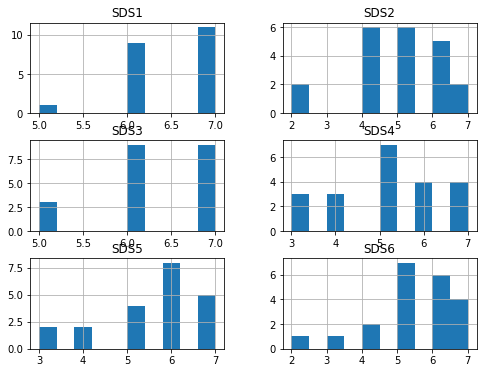

---- Question SDS1 ----
Population Standard Deviation:
0.5870870479018072
Confidence Interval (95%):
(6.202352172836282, 6.750028779544671)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.729, p=0.000
Sample does not look Gaussian (reject H0)


---- Question SDS2 ----
Population Standard Deviation:
1.319657758147716
Confidence Interval (95%):
(4.241607490128914, 5.4726782241568)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.914, p=0.066
Sample looks Gaussian (fail to reject H0)


---- Question SDS3 ----
Population Standard Deviation:
0.6998542122237651
Confidence Interval (95%):
(5.959277361657504, 6.612151209771067)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.788, p=0.000
Sample does not look Gaussian (reject H0)


---- Question SDS4 ----
Population Standard Deviation:
1.2830660557435696
Confidence Interval (95%):
(4.544389448753043, 5.741324836961243)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.910, p=0.055
Sample looks Gaussian (fail to reject H0)


---- Question SDS5 ----

In [189]:
print_stats(data_sds, hist_bins=10)
for column in data_sds:
    print('---- Question', column,'----')
    print('Population Standard Deviation:')
    print(data_sds[column].std(ddof=0))
    print('Confidence Interval (95%):')
    print(confidence_interval_t(data_sds[column]))
    print('Normality Tests:')
    normality_tests(data_sds[column])
    print('\n')

### Response Frequency

In [190]:
data_sds_freq = (data_sds.apply(pd.value_counts).fillna(0)/data_sds.count()*100).transpose()
data_sds_freq

,2,3,4,5,6,7
SDS1,0.000000,0.000000,0.000000,4.761905,42.857143,52.380952
SDS2,9.523810,0.000000,28.571429,28.571429,23.809524,9.523810
SDS3,0.000000,0.000000,0.000000,14.285714,42.857143,42.857143
SDS4,0.000000,14.285714,14.285714,33.333333,19.047619,19.047619
SDS5,0.000000,9.523810,9.523810,19.047619,38.095238,23.809524
SDS6,4.761905,4.761905,9.523810,33.333333,28.571429,19.047619


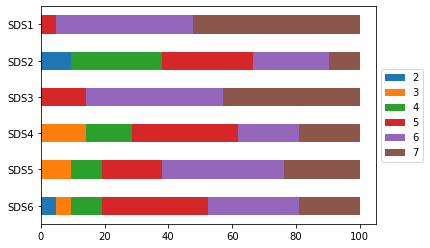

In [191]:
data_sds_freq.iloc[::-1].plot.barh(stacked=True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

### Correlation

In [192]:
calculate_correlation(data_sds);

Kendall Correlation


,SDS1,SDS2,SDS3,SDS4,SDS5,SDS6
SDS1,1.000000,0.268754,0.599616,0.161234,0.300645,0.141873
SDS2,0.268754,1.000000,0.424970,0.790591,0.566306,0.591047
SDS3,0.599616,0.424970,1.000000,0.315919,0.463725,0.299700
SDS4,0.161234,0.790591,0.315919,1.000000,0.662831,0.680521
SDS5,0.300645,0.566306,0.463725,0.662831,1.000000,0.658637
SDS6,0.141873,0.591047,0.299700,0.680521,0.658637,1.000000


,SDS1,SDS2,SDS3,SDS4,SDS5,SDS6
SDS1,1.000000,0.176046,0.004221,0.414123,0.131546,0.474862
SDS2,0.176046,1.000000,0.028420,0.000015,0.002165,0.001311
SDS3,0.004221,0.028420,1.000000,0.101226,0.017192,0.122057
SDS4,0.414123,0.000015,0.101226,1.000000,0.000305,0.000198
SDS5,0.131546,0.002165,0.017192,0.000305,1.000000,0.000359
SDS6,0.474862,0.001311,0.122057,0.000198,0.000359,1.000000


### Overall Pseudo-Semantic Differential Scale Score

In [193]:
data_sds_score = data_sds.mean(axis=1)
data_sds_score

0     6.666667
1     6.333333
2     4.333333
3     6.666667
4     6.333333
5     6.666667
6     7.000000
7     6.166667
8     5.500000
9     5.666667
10    5.833333
11    5.166667
12    4.500000
13    4.666667
14    6.166667
15    4.833333
16    4.500000
17    4.333333
18    5.333333
19    5.666667
20    5.500000
dtype: float64

In [194]:
data_sds_score.describe()

count    21.000000
mean      5.611111
std       0.852013
min       4.333333
25%       4.833333
50%       5.666667
75%       6.333333
max       7.000000
dtype: float64

## NPS

In [195]:
data_nps = data['NPS']
data_nps

,NPS
0,9
1,8
2,9
3,9
4,8
5,7
6,10
7,10
8,10
9,9


### Calculate NPS

In [196]:
nps_count = data_nps['NPS'].count()
nps_promoters = data_nps['NPS'][data_nps['NPS'] >= 9].count()
nps_detractors = data_nps['NPS'][data_nps['NPS'] <= 6].count()

nps_promoters_per = nps_promoters/nps_count*100
nps_detractors_per = nps_detractors/nps_count*100

nps_score = nps_promoters_per - nps_detractors_per
print('NPS Count', nps_count)
print('NPS Promoters', nps_promoters)
print('NPS Detractors', nps_detractors)
print('NPS Promoters (Percentage)', nps_promoters_per)
print('NPS Detractors (Percentage)', nps_detractors_per)

NPS Count 21
NPS Promoters 8
NPS Detractors 2
NPS Promoters (Percentage) 38.095238095238095
NPS Detractors (Percentage) 9.523809523809524


### General Stats

--- Statistics ----


count    21.000000
mean      8.047619
std       1.244033
min       6.000000
25%       7.000000
50%       8.000000
75%       9.000000
max      10.000000
Name: NPS, dtype: float64



--- Counting Unique Values ----


7     6
9     5
8     5
10    3
6     2
Name: NPS, dtype: int64



--- Basic Bar Chart ----


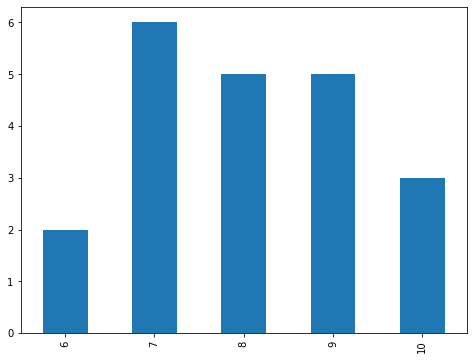

Population Standard Deviation:
1.2140522651411392
Confidence Interval (95%):
(7.481341842802955, 8.61389625243514)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.918, p=0.081
Sample looks Gaussian (fail to reject H0)




In [197]:
print_stats(data_nps['NPS'])
print('Population Standard Deviation:')
print(data_nps['NPS'].std(ddof=0))
print('Confidence Interval (95%):')
print(confidence_interval_t(data_nps['NPS']))
print('Normality Tests:')
normality_tests(data_nps['NPS'])
print('\n')

## NASA TLX

In [198]:
data_nasa_tlx = data['NASA TLX']
data_nasa_tlx['NASA TLX Score'] = data_nasa_tlx.mean(axis=1)
data_nasa_tlx

,Mental Demand,Physical Demand,Temporal Demand,Performance,Effort,Frustration,NASA TLX Score
0,60,20,35,10,30,15,28.333333
1,45,0,45,15,25,5,22.500000
2,75,35,50,30,70,35,49.166667
3,65,0,85,10,40,15,35.833333
4,15,5,5,10,90,0,20.833333
5,45,0,75,60,85,10,45.833333
6,10,0,10,15,35,5,12.500000
7,10,0,0,5,5,0,3.333333
8,30,0,5,25,10,10,13.333333
9,10,10,15,15,35,15,16.666667


--- Statistics ----


,Mental Demand,Physical Demand,Temporal Demand,Performance,Effort,Frustration,NASA TLX Score
count,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
mean,46.190476,7.619048,32.857143,22.857143,38.333333,13.571429,26.904762
std,22.633204,9.568052,28.309514,16.701155,25.016661,15.901482,14.026619
min,10.000000,0.000000,0.000000,5.000000,5.000000,0.000000,3.333333
25%,30.000000,0.000000,10.000000,15.000000,20.000000,5.000000,15.833333
50%,50.000000,5.000000,25.000000,15.000000,35.000000,10.000000,22.500000
75%,65.000000,15.000000,50.000000,25.000000,45.000000,15.000000,35.000000
max,75.000000,35.000000,85.000000,65.000000,90.000000,65.000000,52.500000




--- Counting Unique Values ----


Mental Demand  Physical Demand  Temporal Demand  Performance  Effort  Frustration  NASA TLX Score
10             0                0                5            5       0            3.333333          1
55             15               25               35           45      20           32.500000         1
75             0                50               50           75      65           52.500000         1
70             15               80               15           20      10           35.000000         1
               10               60               25           25      10           33.333333         1
65             15               70               65           45      40           50.000000         1
               5                15               15           20      0            20.000000         1
               0                85               10           40      15           35.833333         1
60             20               35               10           30      15      



--- Basic Histogram ----


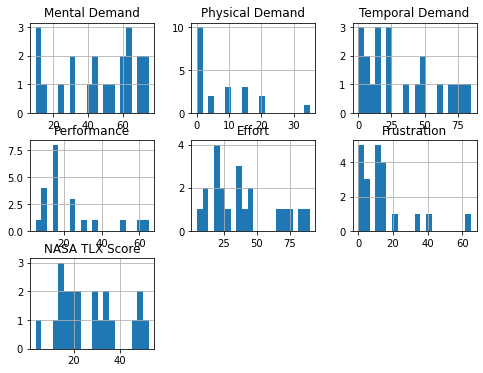

---- Question Mental Demand ----
Population Standard Deviation:
22.087745034874512
Confidence Interval (95%):
(35.88796543523685, 56.49298694571553)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.904, p=0.041
Sample does not look Gaussian (reject H0)


---- Question Physical Demand ----
Population Standard Deviation:
9.337462643394085
Confidence Interval (95%):
(3.2637225662491893, 11.974372671846048)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.797, p=0.001
Sample does not look Gaussian (reject H0)


---- Question Temporal Demand ----
Population Standard Deviation:
27.627256579733885
Confidence Interval (95%):
(19.97080667384029, 45.74347904044542)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.904, p=0.041
Sample does not look Gaussian (reject H0)


---- Question Performance ----
Population Standard Deviation:
16.298658181071264
Confidence Interval (95%):
(15.254868340603, 30.459417373682715)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.785, p=0.000
Sample does not look Gauss

In [199]:
print_stats(data_nasa_tlx, hist_bins=20)
for column in data_nasa_tlx:
    print('---- Question', column,'----')
    print('Population Standard Deviation:')
    print(data_nasa_tlx[column].std(ddof=0))
    print('Confidence Interval (95%):')
    print(confidence_interval_t(data_nasa_tlx[column]))
    print('Normality Tests:')
    normality_tests(data_nasa_tlx[column])
    print('\n')

### Correlation

In [200]:
calculate_correlation(data_nasa_tlx);

Kendall Correlation


,Mental Demand,Physical Demand,Temporal Demand,Performance,Effort,Frustration,NASA TLX Score
Mental Demand,1.000000,0.214985,0.527638,0.328761,0.196474,0.495293,0.657060
Physical Demand,0.214985,1.000000,0.147095,0.018203,0.056718,0.142371,0.176655
Temporal Demand,0.527638,0.147095,1.000000,0.334150,0.277079,0.442602,0.666867
Performance,0.328761,0.018203,0.334150,1.000000,0.297171,0.457744,0.410203
Effort,0.196474,0.056718,0.277079,0.297171,1.000000,0.433154,0.486664
Frustration,0.495293,0.142371,0.442602,0.457744,0.433154,1.000000,0.580986
NASA TLX Score,0.657060,0.176655,0.666867,0.410203,0.486664,0.580986,1.000000


,Mental Demand,Physical Demand,Temporal Demand,Performance,Effort,Frustration,NASA TLX Score
Mental Demand,1.000000,0.218321,0.001341,0.054771,0.233077,0.003562,0.000047
Physical Demand,0.218321,1.000000,0.399488,0.920244,0.745646,0.430173,0.302099
Temporal Demand,0.001341,0.399488,1.000000,0.050845,0.092528,0.009180,0.000036
Performance,0.054771,0.920244,0.050845,1.000000,0.082898,0.009640,0.014507
Effort,0.233077,0.745646,0.092528,0.082898,1.000000,0.010899,0.002596
Frustration,0.003562,0.430173,0.009180,0.009640,0.010899,1.000000,0.000488
NASA TLX Score,0.000047,0.302099,0.000036,0.014507,0.002596,0.000488,1.000000


## SEQ Exercises

In [201]:
data_seq = data['SEQ']
data_seq

,Exercise 1,Exercise 2,Exercise 3,Exercise 4,Exercise 5,Exercise 6,Exercise 7,Exercise 8,Exercise 9,Exercise 10,Exercise 11
0,6,6,7,7,7,7,6,7,6,7,7
1,6,6,7,7,7,7,7,7,7,7,7
2,6,5,7,7,7,7,7,7,6,7,7
3,6,5,6,7,6,7,5,7,4,6,7
4,6,5,7,7,7,7,6,7,5,7,7
5,3,2,3,7,6,7,4,7,1,7,6
6,7,6,7,7,7,6,7,7,6,7,7
7,6,6,6,7,7,7,6,7,6,7,7
8,5,5,6,7,7,7,6,7,6,7,7
9,5,5,6,5,6,6,5,6,4,5,6


--- Statistics ----


,Exercise 1,Exercise 2,Exercise 3,Exercise 4,Exercise 5,Exercise 6,Exercise 7,Exercise 8,Exercise 9,Exercise 10,Exercise 11
count,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
mean,5.666667,5.047619,6.000000,6.809524,6.714286,6.619048,5.857143,6.571429,5.142857,6.571429,6.571429
std,1.016530,0.973457,1.224745,0.511766,0.462910,0.669043,0.792825,0.870140,1.424279,0.810643,0.676123
min,3.000000,2.000000,3.000000,5.000000,6.000000,5.000000,4.000000,4.000000,1.000000,4.000000,5.000000
25%,5.000000,5.000000,6.000000,7.000000,6.000000,6.000000,5.000000,7.000000,5.000000,6.000000,6.000000
50%,6.000000,5.000000,6.000000,7.000000,7.000000,7.000000,6.000000,7.000000,6.000000,7.000000,7.000000
75%,6.000000,6.000000,7.000000,7.000000,7.000000,7.000000,6.000000,7.000000,6.000000,7.000000,7.000000
max,7.000000,6.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000




--- Counting Unique Values ----


Exercise 1  Exercise 2  Exercise 3  Exercise 4  Exercise 5  Exercise 6  Exercise 7  Exercise 8  Exercise 9  Exercise 10  Exercise 11
6           5           7           7           7           7           7           7           6           7            7              2
3           2           3           7           6           7           4           7           1           7            6              1
4           5           6           6           6           5           6           5           6           6            6              1
7           6           6           6           6           6           6           5           6           7            7              1
                        4           7           7           7           6           7           6           7            7              1
6           6           7           7           7           7           7           7           7           7            7              1
                                       



--- Basic Histogram ----


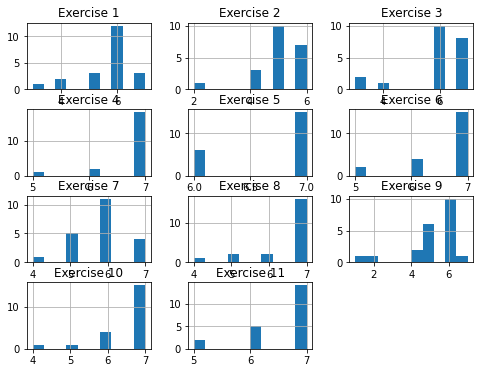

---- Question Exercise 1 ----
Population Standard Deviation:
0.9920317455237933
Confidence Interval (95%):
(5.203947737610729, 6.129385595722605)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.819, p=0.001
Sample does not look Gaussian (reject H0)


---- Question Exercise 2 ----
Population Standard Deviation:
0.9499970163457142
Confidence Interval (95%):
(4.604506612968354, 5.490731482269741)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.785, p=0.000
Sample does not look Gaussian (reject H0)


---- Question Exercise 3 ----
Population Standard Deviation:
1.1952286093343936
Confidence Interval (95%):
(5.44250281849981, 6.55749718150019)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.712, p=0.000
Sample does not look Gaussian (reject H0)


---- Question Exercise 4 ----
Population Standard Deviation:
0.4994327848429292
Confidence Interval (95%):
(6.5765705755363975, 7.042477043511221)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.434, p=0.000
Sample does not look Gaussian (reject H0)

In [202]:
print_stats(data_seq, hist_bins=10)
for column in data_seq:
    print('---- Question', column,'----')
    print('Population Standard Deviation:')
    print(data_seq[column].std(ddof=0))
    print('Confidence Interval (95%):')
    print(confidence_interval_t(data_seq[column]))
    print('Normality Tests:')
    normality_tests(data_seq[column])
    print('\n')

### Response Frequency

In [203]:
data_seq_freq = (data_seq.apply(pd.value_counts).fillna(0)/data_seq.count()*100).transpose()
data_seq_freq

,1,2,3,4,5,6,7
Exercise 1,0.000000,0.000000,4.761905,9.523810,14.285714,57.142857,14.285714
Exercise 2,0.000000,4.761905,0.000000,14.285714,47.619048,33.333333,0.000000
Exercise 3,0.000000,0.000000,9.523810,4.761905,0.000000,47.619048,38.095238
Exercise 4,0.000000,0.000000,0.000000,0.000000,4.761905,9.523810,85.714286
Exercise 5,0.000000,0.000000,0.000000,0.000000,0.000000,28.571429,71.428571
Exercise 6,0.000000,0.000000,0.000000,0.000000,9.523810,19.047619,71.428571
Exercise 7,0.000000,0.000000,0.000000,4.761905,23.809524,52.380952,19.047619
Exercise 8,0.000000,0.000000,0.000000,4.761905,9.523810,9.523810,76.190476
Exercise 9,4.761905,4.761905,0.000000,9.523810,28.571429,47.619048,4.761905
Exercise 10,0.000000,0.000000,0.000000,4.761905,4.761905,19.047619,71.428571


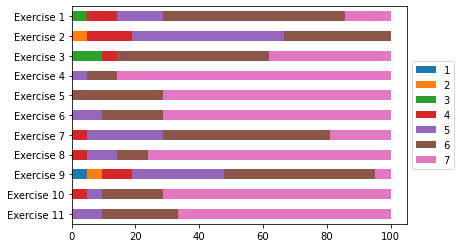

In [204]:
data_seq_freq.iloc[::-1].plot.barh(stacked=True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

### Correlation

In [205]:
calculate_correlation(data_seq);

Kendall Correlation


,Exercise 1,Exercise 2,Exercise 3,Exercise 4,Exercise 5,Exercise 6,Exercise 7,Exercise 8,Exercise 9,Exercise 10,Exercise 11
Exercise 1,1.000000,0.539624,0.036630,0.125585,0.225143,-0.069043,0.500013,0.255010,0.440948,0.369225,0.608358
Exercise 2,0.539624,1.000000,0.144428,-0.078776,0.008877,-0.110591,0.328580,0.071819,0.620926,0.338558,0.388973
Exercise 3,0.036630,0.144428,1.000000,0.171881,0.397706,0.121268,0.356385,0.027423,0.238845,0.060327,0.024754
Exercise 4,0.125585,-0.078776,0.171881,1.000000,0.633866,0.593944,0.136013,0.641028,-0.010947,0.362620,0.231455
Exercise 5,0.225143,0.008877,0.397706,0.633866,1.000000,0.489805,0.518560,0.359573,0.198616,0.275445,0.344862
Exercise 6,-0.069043,-0.110591,0.121268,0.593944,0.489805,1.000000,0.025704,0.355353,-0.107581,0.304572,0.145803
Exercise 7,0.500013,0.328580,0.356385,0.136013,0.518560,0.025704,1.000000,0.207960,0.674018,0.358034,0.603966
Exercise 8,0.255010,0.071819,0.027423,0.641028,0.359573,0.355353,0.207960,1.000000,0.192127,0.632111,0.512881
Exercise 9,0.440948,0.620926,0.238845,-0.010947,0.198616,-0.107581,0.674018,0.192127,1.000000,0.502249,0.409919
Exercise 10,0.369225,0.338558,0.060327,0.362620,0.275445,0.304572,0.358034,0.632111,0.502249,1.000000,0.464207


,Exercise 1,Exercise 2,Exercise 3,Exercise 4,Exercise 5,Exercise 6,Exercise 7,Exercise 8,Exercise 9,Exercise 10,Exercise 11
Exercise 1,1.000000,0.005967,0.853148,0.539874,0.279124,0.732468,0.010652,0.203609,0.022132,0.066311,0.002549
Exercise 2,0.005967,1.000000,0.471181,0.704252,0.966400,0.588810,0.097516,0.723728,0.001466,0.096453,0.056821
Exercise 3,0.853148,0.471181,1.000000,0.411492,0.061302,0.556671,0.074694,0.893526,0.224889,0.768965,0.904326
Exercise 4,0.539874,0.704252,0.411492,1.000000,0.003988,0.005439,0.511188,0.002518,0.957147,0.088217,0.277821
Exercise 5,0.279124,0.966400,0.061302,0.003988,1.000000,0.023991,0.013635,0.095164,0.336994,0.202241,0.111341
Exercise 6,0.732468,0.588810,0.556671,0.005439,0.023991,1.000000,0.899775,0.089311,0.592221,0.146307,0.487972
Exercise 7,0.010652,0.097516,0.074694,0.511188,0.013635,0.899775,1.000000,0.304874,0.000537,0.078034,0.003030
Exercise 8,0.203609,0.723728,0.893526,0.002518,0.095164,0.089311,0.304874,1.000000,0.335469,0.002397,0.014024
Exercise 9,0.022132,0.001466,0.224889,0.957147,0.336994,0.592221,0.000537,0.335469,1.000000,0.012012,0.040901
Exercise 10,0.066311,0.096453,0.768965,0.088217,0.202241,0.146307,0.078034,0.002397,0.012012,1.000000,0.026548


### Overall Pseudo-SEQ Score

In [206]:
data_seq_score = data_seq.mean(axis=1)
data_seq_score

0     6.636364
1     6.818182
2     6.636364
3     6.000000
4     6.454545
5     4.818182
6     6.727273
7     6.545455
8     6.363636
9     5.363636
10    6.454545
11    6.181818
12    5.545455
13    6.000000
14    6.000000
15    6.090909
16    6.000000
17    5.181818
18    6.363636
19    6.636364
20    6.181818
dtype: float64

In [207]:
data_seq_score.describe()

count    21.000000
mean      6.142857
std       0.534412
min       4.818182
25%       6.000000
50%       6.181818
75%       6.545455
max       6.818182
dtype: float64

## Exercises

In [208]:
data_exercises = data['Exercises'].copy()

data_exercises_times = data_exercises.select_dtypes(include='object')
data_exercises_times = data_exercises_times.applymap(convert_time_to_timedelta, na_action='ignore')
data_exercises_times = data_exercises_times / np.timedelta64(1, 's')

data_exercises[data_exercises_times.columns] = data_exercises_times[data_exercises_times.columns]

display(data_exercises)
display(data_exercises.describe())
for column in data_exercises:
    print('---- Question', column,'----')
    print('Population Standard Deviation:')
    print(data_exercises[column].std(ddof=0))
    print('Confidence Interval (95%):')
    print(confidence_interval_t(data_exercises[column]))
    print('Normality Tests:')
    normality_tests(data_exercises[column])
    print('\n')

,Exercise 1 Total Time,Exercise 1 Time First Needed Help,Exercise 1 Times Needed Help,Exercise 1 Number of Errors,Exercise 2 Total Time,Exercise 2 Time First Needed Help,Exercise 2 Times Needed Help,Exercise 2 Number of Errors,Exercise 3 Total Time,Exercise 3 Time First Needed Help,...,Exercise 9 Times Needed Help,Exercise 9 Number of Errors,Exercise 10 Total Time,Exercise 10 Time First Needed Help,Exercise 10 Times Needed Help,Exercise 10 Number of Errors,Exercise 11 Total Time,Exercise 11 Time First Needed Help,Exercise 11 Times Needed Help,Exercise 11 Number of Errors
0,86.0,NaN,0,0,336.0,154.0,5,1,48.0,32.0,...,2,1,39.0,NaN,0,0,11.0,NaN,0,0
1,201.0,144.0,1,2,255.0,40.0,3,3,30.0,NaN,...,2,2,31.0,NaN,0,0,20.0,NaN,0,0
2,176.0,93.0,2,0,280.0,13.0,7,5,88.0,17.0,...,1,0,46.0,12.0,1,1,30.0,16.0,1,1
3,104.0,NaN,3,0,358.0,33.0,8,3,12.0,30.0,...,3,1,64.0,37.0,1,1,25.0,NaN,0,0
4,133.0,49.0,3,1,284.0,43.0,5,3,92.0,39.0,...,1,0,38.0,NaN,0,0,24.0,NaN,0,0
5,250.0,51.0,4,0,285.0,74.0,5,2,110.0,33.0,...,4,2,83.0,21.0,2,1,32.0,21.0,1,1
6,169.0,62.0,2,1,196.0,21.0,3,2,82.0,39.0,...,4,0,31.0,31.0,1,1,25.0,NaN,0,0
7,130.0,62.0,1,0,243.0,105.0,5,2,190.0,40.0,...,2,1,58.0,NaN,0,0,32.0,32.0,1,0
8,107.0,217.0,3,0,259.0,14.0,4,3,133.0,97.0,...,3,0,78.0,55.0,1,1,34.0,NaN,0,0


,Exercise 1 Total Time,Exercise 1 Time First Needed Help,Exercise 1 Times Needed Help,Exercise 1 Number of Errors,Exercise 2 Total Time,Exercise 2 Time First Needed Help,Exercise 2 Times Needed Help,Exercise 2 Number of Errors,Exercise 3 Total Time,Exercise 3 Time First Needed Help,...,Exercise 9 Times Needed Help,Exercise 9 Number of Errors,Exercise 10 Total Time,Exercise 10 Time First Needed Help,Exercise 10 Times Needed Help,Exercise 10 Number of Errors,Exercise 11 Total Time,Exercise 11 Time First Needed Help,Exercise 11 Times Needed Help,Exercise 11 Number of Errors
count,9.000000,7.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,8.000000,...,9.000000,9.000000,9.00000,5.000000,9.000000,9.000000,9.000000,3.000000,9.000000,9.000000
mean,150.666667,96.857143,2.111111,0.444444,277.333333,55.222222,5.000000,2.666667,87.222222,40.875000,...,2.444444,0.777778,52.00000,31.200000,0.666667,0.555556,25.888889,23.000000,0.333333,0.222222
std,52.896125,62.576429,1.269296,0.726483,48.332184,47.586179,1.658312,1.118034,54.428342,23.865322,...,1.130388,0.833333,19.68502,16.376813,0.707107,0.527046,7.236098,8.185353,0.500000,0.440959
min,86.000000,49.000000,0.000000,0.000000,196.000000,13.000000,3.000000,1.000000,12.000000,17.000000,...,1.000000,0.000000,31.00000,12.000000,0.000000,0.000000,11.000000,16.000000,0.000000,0.000000
25%,107.000000,56.500000,1.000000,0.000000,255.000000,21.000000,4.000000,2.000000,48.000000,31.500000,...,2.000000,0.000000,38.00000,21.000000,0.000000,0.000000,24.000000,18.500000,0.000000,0.000000
50%,133.000000,62.000000,2.000000,0.000000,280.000000,40.000000,5.000000,3.000000,88.000000,36.000000,...,2.000000,1.000000,46.00000,31.000000,1.000000,1.000000,25.000000,21.000000,0.000000,0.000000
75%,176.000000,118.500000,3.000000,1.000000,285.000000,74.000000,5.000000,3.000000,110.000000,39.250000,...,3.000000,1.000000,64.00000,37.000000,1.000000,1.000000,32.000000,26.500000,1.000000,0.000000
max,250.000000,217.000000,4.000000,2.000000,358.000000,154.000000,8.000000,5.000000,190.000000,97.000000,...,4.000000,2.000000,83.00000,55.000000,2.000000,1.000000,34.000000,32.000000,1.000000,1.000000


---- Question Exercise 1 Total Time ----
Population Standard Deviation:
49.870944558040115
Confidence Interval (95%):
(110.0071059649992, 191.32622736833412)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.944, p=0.627
Sample looks Gaussian (fail to reject H0)


---- Question Exercise 1 Time First Needed Help ----
Population Standard Deviation:
57.93451616493665
Confidence Interval (95%):
(38.98359818292664, 154.73068753135908)
Normality Tests:
Shapiro-Wilk Test
Statistics=nan, p=1.000
Sample looks Gaussian (fail to reject H0)


---- Question Exercise 1 Times Needed Help ----
Population Standard Deviation:
1.1967032904743342
Confidence Interval (95%):
(1.1354442070223274, 3.086778015199895)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.948, p=0.663
Sample looks Gaussian (fail to reject H0)


---- Question Exercise 1 Number of Errors ----
Population Standard Deviation:
0.6849348892187752
Confidence Interval (95%):
(-0.11397994377763243, 1.0028688326665214)
Normality Tests:
Shapiro-Wil

/home/pedro/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/pedro/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/home/pedro/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1757: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


In [209]:
data_exercises_seq = pd.concat([data_seq, data_exercises], axis=1)
data_exercises_seq

,Exercise 1,Exercise 2,Exercise 3,Exercise 4,Exercise 5,Exercise 6,Exercise 7,Exercise 8,Exercise 9,Exercise 10,...,Exercise 9 Times Needed Help,Exercise 9 Number of Errors,Exercise 10 Total Time,Exercise 10 Time First Needed Help,Exercise 10 Times Needed Help,Exercise 10 Number of Errors,Exercise 11 Total Time,Exercise 11 Time First Needed Help,Exercise 11 Times Needed Help,Exercise 11 Number of Errors
0,6,6,7,7,7,7,6,7,6,7,...,2.0,1.0,39.0,NaN,0.0,0.0,11.0,NaN,0.0,0.0
1,6,6,7,7,7,7,7,7,7,7,...,2.0,2.0,31.0,NaN,0.0,0.0,20.0,NaN,0.0,0.0
2,6,5,7,7,7,7,7,7,6,7,...,1.0,0.0,46.0,12.0,1.0,1.0,30.0,16.0,1.0,1.0
3,6,5,6,7,6,7,5,7,4,6,...,3.0,1.0,64.0,37.0,1.0,1.0,25.0,NaN,0.0,0.0
4,6,5,7,7,7,7,6,7,5,7,...,1.0,0.0,38.0,NaN,0.0,0.0,24.0,NaN,0.0,0.0
5,3,2,3,7,6,7,4,7,1,7,...,4.0,2.0,83.0,21.0,2.0,1.0,32.0,21.0,1.0,1.0
6,7,6,7,7,7,6,7,7,6,7,...,4.0,0.0,31.0,31.0,1.0,1.0,25.0,NaN,0.0,0.0
7,6,6,6,7,7,7,6,7,6,7,...,2.0,1.0,58.0,NaN,0.0,0.0,32.0,32.0,1.0,0.0
8,5,5,6,7,7,7,6,7,6,7,...,3.0,0.0,78.0,55.0,1.0,1.0,34.0,NaN,0.0,0.0
9,5,5,6,5,6,6,5,6,4,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


[-------------------------------- [Exercise 1] --------------------------------]


,Exercise 1,Exercise 1 Total Time,Exercise 1 Times Needed Help,Exercise 1 Number of Errors
0,6,86.0,0.0,0.0
1,6,201.0,1.0,2.0
2,6,176.0,2.0,0.0
3,6,104.0,3.0,0.0
4,6,133.0,3.0,1.0
5,3,250.0,4.0,0.0
6,7,169.0,2.0,1.0
7,6,130.0,1.0,0.0
8,5,107.0,3.0,0.0


Correlations:
Kendall Correlation


,Exercise 1,Exercise 1 Total Time,Exercise 1 Times Needed Help,Exercise 1 Number of Errors
Exercise 1,1.000000,-0.109109,-0.470317,0.439155
Exercise 1 Total Time,-0.109109,1.000000,0.149671,0.372678
Exercise 1 Times Needed Help,-0.470317,0.149671,1.000000,-0.160644
Exercise 1 Number of Errors,0.439155,0.372678,-0.160644,1.000000


,Exercise 1,Exercise 1 Total Time,Exercise 1 Times Needed Help,Exercise 1 Number of Errors
Exercise 1,1.000000,0.706931,0.122086,0.175699
Exercise 1 Total Time,0.706931,1.000000,0.590493,0.206507
Exercise 1 Times Needed Help,0.122086,0.590493,1.000000,0.603703
Exercise 1 Number of Errors,0.175699,0.206507,0.603703,1.000000


---- Question Exercise 1 ----
Population Standard Deviation:
1.0540925533894598
Confidence Interval (95%):
(4.807269666278297, 6.526063667055037)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.718, p=0.002
Sample does not look Gaussian (reject H0)


---- Question Exercise 1 Total Time ----
Population Standard Deviation:
49.870944558040115
Confidence Interval (95%):
(110.0071059649992, 191.32622736833412)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.944, p=0.627
Sample looks Gaussian (fail to reject H0)


---- Question Exercise 1 Times Needed Help ----
Population Standard Deviation:
1.1967032904743342
Confidence Interval (95%):
(1.1354442070223274, 3.086778015199895)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.948, p=0.663
Sample looks Gaussian (fail to reject H0)


---- Question Exercise 1 Number of Errors ----
Population Standard Deviation:
0.6849348892187752
Confidence Interval (95%):
(-0.11397994377763243, 1.0028688326665214)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.6

,Exercise 1,Exercise 1 Total Time,Exercise 1 Times Needed Help,Exercise 1 Number of Errors
0,0.641936,0.463500,0.579948,0.191693
1,0.119861,0.582184,0.067753,0.801314
2,0.385971,0.359933,0.804732,0.271812
3,0.651596,0.562741,0.107133,0.497260


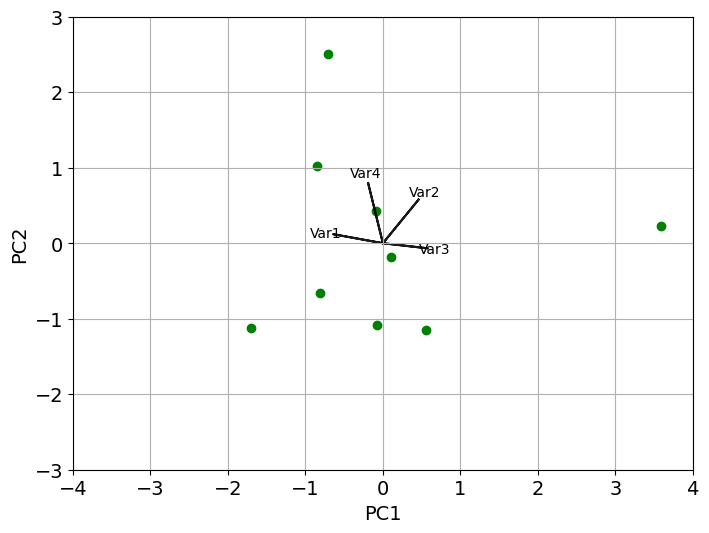

[-------------------------------- [Exercise 2] --------------------------------]


,Exercise 2,Exercise 2 Total Time,Exercise 2 Times Needed Help,Exercise 2 Number of Errors
0,6,336.0,5.0,1.0
1,6,255.0,3.0,3.0
2,5,280.0,7.0,5.0
3,5,358.0,8.0,3.0
4,5,284.0,5.0,3.0
5,2,285.0,5.0,2.0
6,6,196.0,3.0,2.0
7,6,243.0,5.0,2.0
8,5,259.0,4.0,3.0


Correlations:
Kendall Correlation


,Exercise 2,Exercise 2 Total Time,Exercise 2 Times Needed Help,Exercise 2 Number of Errors
Exercise 2,1.000000,-0.476290,-0.416954,-0.353553
Exercise 2 Total Time,-0.476290,1.000000,0.588035,0.032075
Exercise 2 Times Needed Help,-0.416954,0.588035,1.000000,0.178685
Exercise 2 Number of Errors,-0.353553,0.032075,0.178685,1.000000


,Exercise 2,Exercise 2 Total Time,Exercise 2 Times Needed Help,Exercise 2 Number of Errors
Exercise 2,1.000000,0.105193,0.180892,0.266669
Exercise 2 Total Time,0.105193,1.000000,0.036265,0.910794
Exercise 2 Times Needed Help,0.180892,0.036265,1.000000,0.555439
Exercise 2 Number of Errors,0.266669,0.910794,0.555439,1.000000


---- Question Exercise 2 ----
Population Standard Deviation:
1.1967032904743342
Confidence Interval (95%):
(4.135444207022327, 6.0867780151998945)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.685, p=0.001
Sample does not look Gaussian (reject H0)


---- Question Exercise 2 Total Time ----
Population Standard Deviation:
45.56801997502683
Confidence Interval (95%):
(240.18192802812345, 314.48473863854315)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.959, p=0.784
Sample looks Gaussian (fail to reject H0)


---- Question Exercise 2 Times Needed Help ----
Population Standard Deviation:
1.5634719199411433
Confidence Interval (95%):
(3.725308253181044, 6.274691746818956)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.896, p=0.227
Sample looks Gaussian (fail to reject H0)


---- Question Exercise 2 Number of Errors ----
Population Standard Deviation:
1.0540925533894598
Confidence Interval (95%):
(1.8072696662782963, 3.5260636670550367)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.883

,Exercise 2,Exercise 2 Total Time,Exercise 2 Times Needed Help,Exercise 2 Number of Errors
0,0.319355,0.593765,0.673712,0.302603
1,0.305383,0.376350,0.085449,0.870518
2,0.896780,0.355554,0.192480,0.179774
3,0.023218,0.615943,0.708352,0.343966


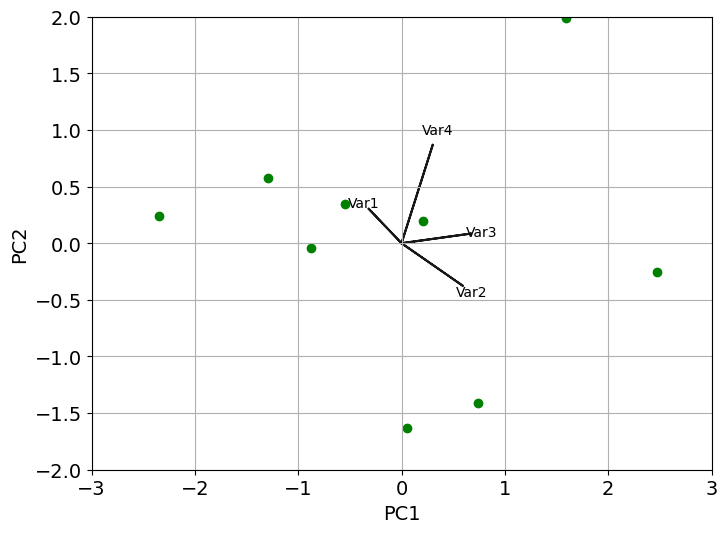

[-------------------------------- [Exercise 3] --------------------------------]


,Exercise 3,Exercise 3 Total Time,Exercise 3 Times Needed Help,Exercise 3 Number of Errors
0,7,48.0,1.0,1.0
1,7,30.0,0.0,0.0
2,7,88.0,3.0,1.0
3,6,12.0,1.0,0.0
4,7,92.0,1.0,0.0
5,3,110.0,3.0,2.0
6,7,82.0,1.0,1.0
7,6,190.0,3.0,0.0
8,6,133.0,1.0,0.0


Correlations:
Kendall Correlation


,Exercise 3,Exercise 3 Total Time,Exercise 3 Times Needed Help,Exercise 3 Number of Errors
Exercise 3,1.000000,-0.312772,-0.434783,0.043478
Exercise 3 Total Time,-0.312772,1.000000,0.521286,0.034752
Exercise 3 Times Needed Help,-0.434783,0.521286,1.000000,0.434783
Exercise 3 Number of Errors,0.043478,0.034752,0.434783,1.000000


,Exercise 3,Exercise 3 Total Time,Exercise 3 Times Needed Help,Exercise 3 Number of Errors
Exercise 3,1.000000,0.287726,0.185280,0.894615
Exercise 3 Total Time,0.287726,1.000000,0.076416,0.905969
Exercise 3 Times Needed Help,0.185280,0.076416,1.000000,0.185280
Exercise 3 Number of Errors,0.894615,0.905969,0.185280,1.000000


---- Question Exercise 3 ----
Population Standard Deviation:
1.227262335243029
Confidence Interval (95%):
(5.221640663984234, 7.222803780460211)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.652, p=0.000
Sample does not look Gaussian (reject H0)


---- Question Exercise 3 Total Time ----
Population Standard Deviation:
51.31553322939638
Confidence Interval (95%):
(45.38489476092195, 129.0595496835225)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.967, p=0.872
Sample looks Gaussian (fail to reject H0)


---- Question Exercise 3 Times Needed Help ----
Population Standard Deviation:
1.0657403385139377
Confidence Interval (95%):
(0.6866621674306844, 2.4244489436804266)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.773, p=0.010
Sample does not look Gaussian (reject H0)


---- Question Exercise 3 Number of Errors ----
Population Standard Deviation:
0.6849348892187752
Confidence Interval (95%):
(-0.0028688326665212704, 1.1139799437776325)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.7

,Exercise 3,Exercise 3 Total Time,Exercise 3 Times Needed Help,Exercise 3 Number of Errors
0,0.525920,0.412495,0.590522,0.452261
1,0.266767,0.717144,0.204266,0.610586
2,0.803403,0.025646,0.388205,0.450758
3,0.082389,0.561155,0.677389,0.468467


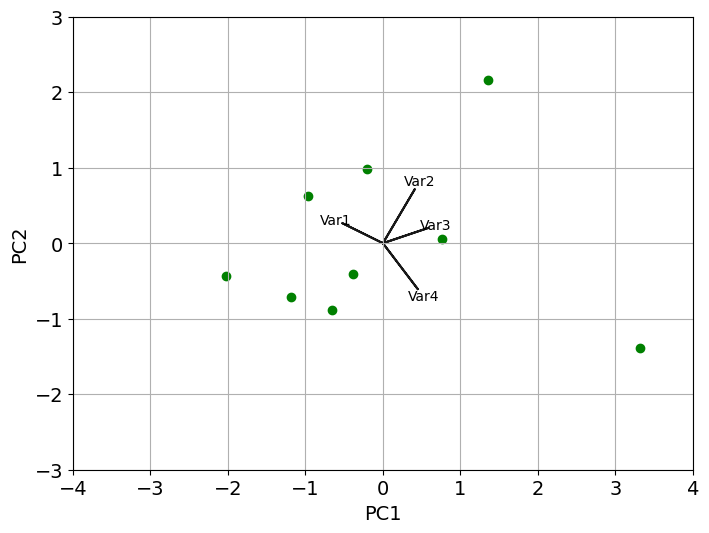

[-------------------------------- [Exercise 4] --------------------------------]


,Exercise 4,Exercise 4 Total Time,Exercise 4 Times Needed Help,Exercise 4 Number of Errors
0,7,61.0,0.0,1.0
1,7,17.0,0.0,0.0
2,7,21.0,0.0,0.0
3,7,8.0,0.0,0.0
4,7,63.0,0.0,0.0
5,7,21.0,0.0,0.0
6,7,16.0,0.0,0.0
7,7,12.0,0.0,0.0
8,7,45.0,0.0,0.0


Correlations:
Kendall Correlation


/home/pedro/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/pedro/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


,Exercise 4,Exercise 4 Total Time,Exercise 4 Times Needed Help,Exercise 4 Number of Errors
Exercise 4,1.0,NaN,NaN,NaN
Exercise 4 Total Time,NaN,1.000000,NaN,0.358569
Exercise 4 Times Needed Help,NaN,NaN,1.0,NaN
Exercise 4 Number of Errors,NaN,0.358569,NaN,1.000000


,Exercise 4,Exercise 4 Total Time,Exercise 4 Times Needed Help,Exercise 4 Number of Errors
Exercise 4,1.000000,nan,nan,nan
Exercise 4 Total Time,nan,1.000000,nan,0.243305
Exercise 4 Times Needed Help,nan,nan,1.000000,nan
Exercise 4 Number of Errors,nan,0.243305,nan,1.000000


---- Question Exercise 4 ----
Population Standard Deviation:
0.0
Confidence Interval (95%):
(nan, nan)
Normality Tests:
Shapiro-Wilk Test
Statistics=1.000, p=1.000
Sample looks Gaussian (fail to reject H0)


---- Question Exercise 4 Total Time ----
Population Standard Deviation:
20.016659728003237
Confidence Interval (95%):
(13.01383911745409, 45.652827549212574)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.820, p=0.035
Sample does not look Gaussian (reject H0)


---- Question Exercise 4 Times Needed Help ----
Population Standard Deviation:
0.0
Confidence Interval (95%):
(nan, nan)
Normality Tests:
Shapiro-Wilk Test
Statistics=1.000, p=1.000
Sample looks Gaussian (fail to reject H0)


---- Question Exercise 4 Number of Errors ----
Population Standard Deviation:
0.31426968052735454
Confidence Interval (95%):
(-0.1451115705592635, 0.3673337927814857)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.390, p=0.000
Sample does not look Gaussian (reject H0)


Explained Variance Ratio: [0.77

/home/pedro/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/pedro/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/home/pedro/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1757: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


,Exercise 4,Exercise 4 Total Time,Exercise 4 Times Needed Help,Exercise 4 Number of Errors
0,0.0,0.707107,0.0,0.707107
1,0.0,0.707107,0.0,0.707107
2,0.0,0.000000,1.0,0.000000
3,1.0,0.000000,0.0,0.000000


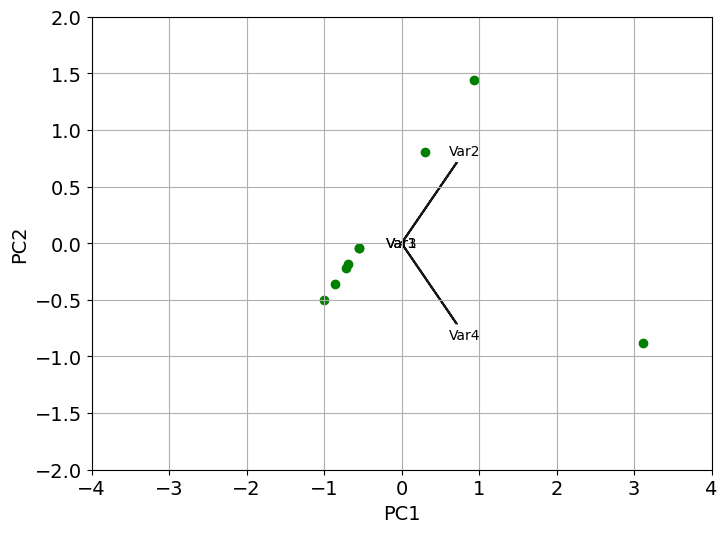

[-------------------------------- [Exercise 5] --------------------------------]


,Exercise 5,Exercise 5 Total Time,Exercise 5 Times Needed Help,Exercise 5 Number of Errors
0,7,17.0,0.0,0.0
1,7,22.0,0.0,0.0
2,7,36.0,0.0,0.0
3,6,35.0,1.0,1.0
4,7,38.0,0.0,0.0
5,6,42.0,1.0,0.0
6,7,42.0,0.0,0.0
7,7,47.0,1.0,0.0
8,7,41.0,0.0,0.0


Correlations:
Kendall Correlation


,Exercise 5,Exercise 5 Total Time,Exercise 5 Times Needed Help,Exercise 5 Number of Errors
Exercise 5,1.000000,-0.045175,-0.755929,-0.661438
Exercise 5 Total Time,-0.045175,1.000000,0.358569,-0.239046
Exercise 5 Times Needed Help,-0.755929,0.358569,1.000000,0.500000
Exercise 5 Number of Errors,-0.661438,-0.239046,0.500000,1.000000


,Exercise 5,Exercise 5 Total Time,Exercise 5 Times Needed Help,Exercise 5 Number of Errors
Exercise 5,1.000000,0.883133,0.032509,0.061369
Exercise 5 Total Time,0.883133,1.000000,0.243305,0.436661
Exercise 5 Times Needed Help,0.032509,0.243305,1.000000,0.157299
Exercise 5 Number of Errors,0.061369,0.436661,0.157299,1.000000


---- Question Exercise 5 ----
Population Standard Deviation:
0.415739709641549
Confidence Interval (95%):
(6.438827029800838, 7.116728525754717)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.536, p=0.000
Sample does not look Gaussian (reject H0)


---- Question Exercise 5 Total Time ----
Population Standard Deviation:
9.2988782012923
Confidence Interval (95%):
(27.974221252916973, 43.136889858194145)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.869, p=0.121
Sample looks Gaussian (fail to reject H0)


---- Question Exercise 5 Times Needed Help ----
Population Standard Deviation:
0.47140452079103173
Confidence Interval (95%):
(-0.051000689172228386, 0.7176673558388951)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.617, p=0.000
Sample does not look Gaussian (reject H0)


---- Question Exercise 5 Number of Errors ----
Population Standard Deviation:
0.3142696805273545
Confidence Interval (95%):
(-0.14511157055926338, 0.3673337927814856)
Normality Tests:
Shapiro-Wilk Test
Statistics=0

,Exercise 5,Exercise 5 Total Time,Exercise 5 Times Needed Help,Exercise 5 Number of Errors
0,0.591078,0.252511,0.585671,0.493817
1,0.171817,0.850584,0.192867,0.458026
2,0.366708,0.410090,0.416833,0.723604
3,0.697589,0.211119,0.667864,0.150848


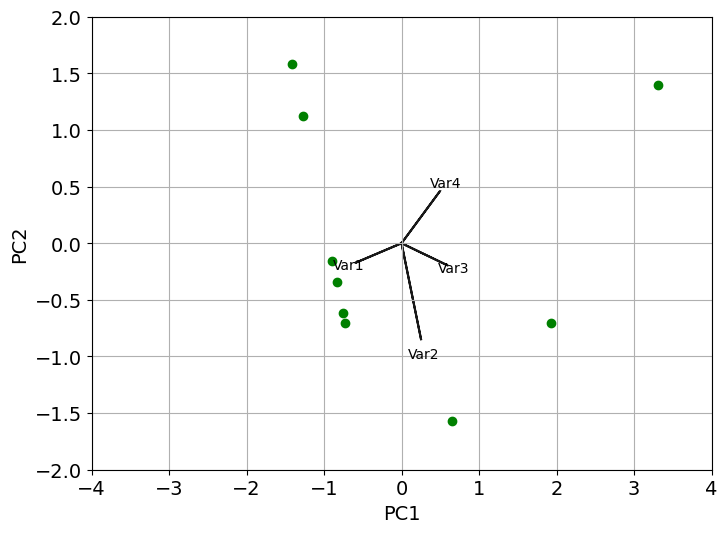

[-------------------------------- [Exercise 6] --------------------------------]


,Exercise 6,Exercise 6 Total Time,Exercise 6 Times Needed Help,Exercise 6 Number of Errors
0,7,15.0,0.0,0.0
1,7,15.0,0.0,0.0
2,7,12.0,0.0,0.0
3,7,11.0,0.0,0.0
4,7,11.0,0.0,0.0
5,7,16.0,0.0,0.0
6,6,33.0,1.0,1.0
7,7,16.0,0.0,0.0
8,7,66.0,0.0,0.0


Correlations:
Kendall Correlation


,Exercise 6,Exercise 6 Total Time,Exercise 6 Times Needed Help,Exercise 6 Number of Errors
Exercise 6,1.000000,-0.369274,-1.000000,-1.000000
Exercise 6 Total Time,-0.369274,1.000000,0.369274,0.369274
Exercise 6 Times Needed Help,-1.000000,0.369274,1.000000,1.000000
Exercise 6 Number of Errors,-1.000000,0.369274,1.000000,1.000000


,Exercise 6,Exercise 6 Total Time,Exercise 6 Times Needed Help,Exercise 6 Number of Errors
Exercise 6,1.000000,0.239317,0.004678,0.004678
Exercise 6 Total Time,0.239317,1.000000,0.239317,0.239317
Exercise 6 Times Needed Help,0.004678,0.239317,1.000000,0.004678
Exercise 6 Number of Errors,0.004678,0.239317,0.004678,1.000000


---- Question Exercise 6 ----
Population Standard Deviation:
0.3142696805273545
Confidence Interval (95%):
(6.632666207218515, 7.145111570559264)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.390, p=0.000
Sample does not look Gaussian (reject H0)


---- Question Exercise 6 Total Time ----
Population Standard Deviation:
16.89181261242657
Confidence Interval (95%):
(7.894846494365099, 35.43848683896824)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.636, p=0.000
Sample does not look Gaussian (reject H0)


---- Question Exercise 6 Times Needed Help ----
Population Standard Deviation:
0.31426968052735443
Confidence Interval (95%):
(-0.14511157055926338, 0.3673337927814856)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.390, p=0.000
Sample does not look Gaussian (reject H0)


---- Question Exercise 6 Number of Errors ----
Population Standard Deviation:
0.31426968052735443
Confidence Interval (95%):
(-0.14511157055926338, 0.3673337927814856)
Normality Tests:
Shapiro-Wilk Test
Statistics=

,Exercise 6,Exercise 6 Total Time,Exercise 6 Times Needed Help,Exercise 6 Number of Errors
0,0.566417,1.936860e-01,0.566417,0.566417
1,0.111825,9.810636e-01,0.111825,0.111825
2,0.816497,7.036113e-18,0.408248,0.408248
3,0.000000,6.331402e-17,0.707107,0.707107


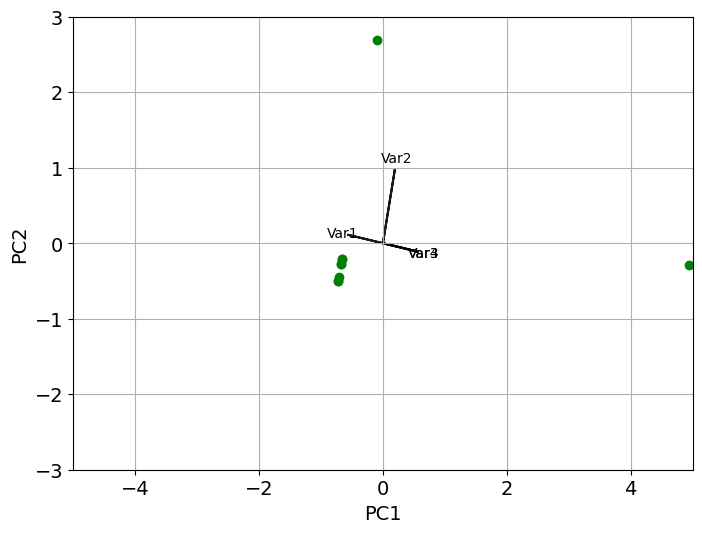

[-------------------------------- [Exercise 7] --------------------------------]


,Exercise 7,Exercise 7 Total Time,Exercise 7 Times Needed Help,Exercise 7 Number of Errors
0,6,88.0,2.0,1.0
1,7,65.0,0.0,0.0
2,7,119.0,1.0,0.0
3,5,13.0,4.0,2.0
4,6,95.0,0.0,0.0
5,4,102.0,2.0,2.0
6,7,86.0,0.0,0.0
7,6,73.0,0.0,0.0
8,6,105.0,0.0,0.0


Correlations:
Kendall Correlation


,Exercise 7,Exercise 7 Total Time,Exercise 7 Times Needed Help,Exercise 7 Number of Errors
Exercise 7,1.000000,0.032075,-0.461880,-0.731564
Exercise 7 Total Time,0.032075,1.000000,-0.033333,-0.149071
Exercise 7 Times Needed Help,-0.461880,-0.033333,1.000000,0.849706
Exercise 7 Number of Errors,-0.731564,-0.149071,0.849706,1.000000


,Exercise 7,Exercise 7 Total Time,Exercise 7 Times Needed Help,Exercise 7 Number of Errors
Exercise 7,1.000000,0.910794,0.137084,0.022042
Exercise 7 Total Time,0.910794,1.000000,0.907663,0.613354
Exercise 7 Times Needed Help,0.137084,0.907663,1.000000,0.008092
Exercise 7 Number of Errors,0.022042,0.613354,0.008092,1.000000


---- Question Exercise 7 ----
Population Standard Deviation:
0.9428090415820634
Confidence Interval (95%):
(5.231331954988876, 6.768668045011124)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.853, p=0.081
Sample looks Gaussian (fail to reject H0)


---- Question Exercise 7 Total Time ----
Population Standard Deviation:
29.14120581827749
Confidence Interval (95%):
(59.13019257005175, 106.64758520772602)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.879, p=0.154
Sample looks Gaussian (fail to reject H0)


---- Question Exercise 7 Times Needed Help ----
Population Standard Deviation:
1.3333333333333333
Confidence Interval (95%):
(-0.08706077421754355, 2.0870607742175435)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.763, p=0.008
Sample does not look Gaussian (reject H0)


---- Question Exercise 7 Number of Errors ----
Population Standard Deviation:
0.8314794192830981
Confidence Interval (95%):
(-0.12234594039832314, 1.2334570515094343)
Normality Tests:
Shapiro-Wilk Test
Statistics=0

,Exercise 7,Exercise 7 Total Time,Exercise 7 Times Needed Help,Exercise 7 Number of Errors
0,0.487970,0.358363,0.549643,0.575633
1,0.505920,0.835829,0.100861,0.187782
2,0.606320,0.415747,0.663408,0.139354
3,0.371895,0.010981,0.497603,0.783559


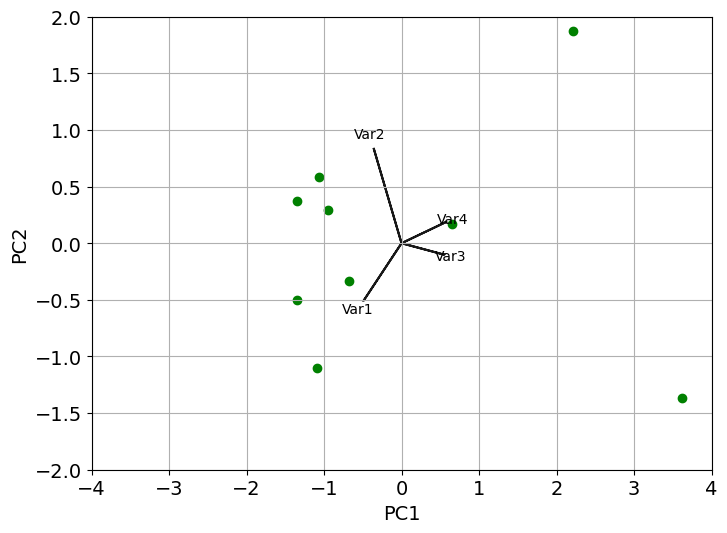

[-------------------------------- [Exercise 8] --------------------------------]


,Exercise 8,Exercise 8 Total Time,Exercise 8 Times Needed Help,Exercise 8 Number of Errors
0,7,30.0,0.0,0.0
1,7,53.0,1.0,1.0
2,7,32.0,0.0,0.0
3,7,28.0,2.0,1.0
4,7,23.0,0.0,0.0
5,7,100.0,1.0,0.0
6,7,43.0,0.0,0.0
7,7,81.0,1.0,2.0
8,7,41.0,0.0,0.0


Correlations:
Kendall Correlation


/home/pedro/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/pedro/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


,Exercise 8,Exercise 8 Total Time,Exercise 8 Times Needed Help,Exercise 8 Number of Errors
Exercise 8,1.0,NaN,NaN,NaN
Exercise 8 Total Time,NaN,1.000000,0.312772,0.223607
Exercise 8 Times Needed Help,NaN,0.312772,1.000000,0.699379
Exercise 8 Number of Errors,NaN,0.223607,0.699379,1.000000


,Exercise 8,Exercise 8 Total Time,Exercise 8 Times Needed Help,Exercise 8 Number of Errors
Exercise 8,1.000000,nan,nan,nan
Exercise 8 Total Time,nan,1.000000,0.287726,0.448489
Exercise 8 Times Needed Help,nan,0.287726,1.000000,0.033640
Exercise 8 Number of Errors,nan,0.448489,0.033640,1.000000


---- Question Exercise 8 ----
Population Standard Deviation:
0.0
Confidence Interval (95%):
(nan, nan)
Normality Tests:
Shapiro-Wilk Test
Statistics=1.000, p=1.000
Sample looks Gaussian (fail to reject H0)


---- Question Exercise 8 Total Time ----
Population Standard Deviation:
24.713668932369497
Confidence Interval (95%):
(27.739943826355656, 68.03783395142212)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.844, p=0.064
Sample looks Gaussian (fail to reject H0)


---- Question Exercise 8 Times Needed Help ----
Population Standard Deviation:
0.6849348892187752
Confidence Interval (95%):
(-0.0028688326665212704, 1.1139799437776325)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.763, p=0.008
Sample does not look Gaussian (reject H0)


---- Question Exercise 8 Number of Errors ----
Population Standard Deviation:
0.6849348892187752
Confidence Interval (95%):
(-0.11397994377763243, 1.0028688326665214)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.684, p=0.001
Sample does not look Gauss

/home/pedro/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/pedro/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/home/pedro/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1757: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


,Exercise 8,Exercise 8 Total Time,Exercise 8 Times Needed Help,Exercise 8 Number of Errors
0,0.0,0.463359,0.625752,0.627481
1,0.0,0.886130,0.333938,0.321339
2,0.0,0.008461,0.704926,0.709231
3,1.0,0.000000,0.000000,0.000000


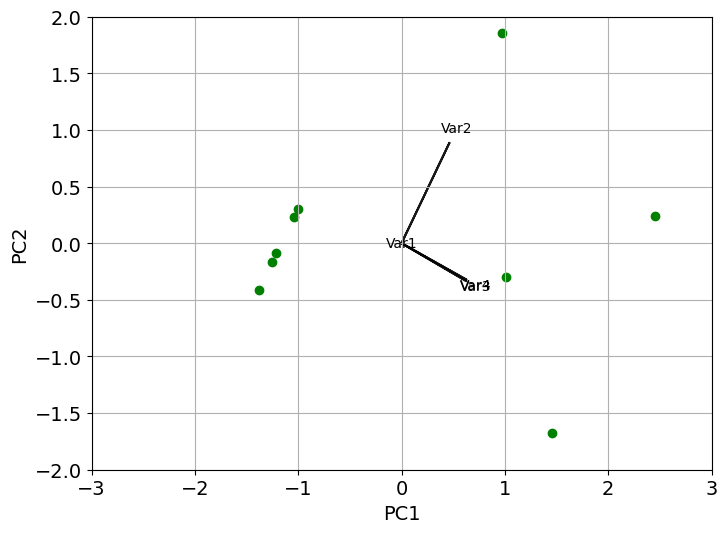

[-------------------------------- [Exercise 9] --------------------------------]


,Exercise 9,Exercise 9 Total Time,Exercise 9 Times Needed Help,Exercise 9 Number of Errors
0,6,106.0,2.0,1.0
1,7,137.0,2.0,2.0
2,6,84.0,1.0,0.0
3,4,124.0,3.0,1.0
4,5,97.0,1.0,0.0
5,1,204.0,4.0,2.0
6,6,178.0,4.0,0.0
7,6,116.0,2.0,1.0
8,6,156.0,3.0,0.0


Correlations:
Kendall Correlation


,Exercise 9,Exercise 9 Total Time,Exercise 9 Times Needed Help,Exercise 9 Number of Errors
Exercise 9,1.000000,-0.130744,-0.250640,-0.076923
Exercise 9 Total Time,-0.130744,1.000000,0.852013,0.326860
Exercise 9 Times Needed Help,-0.250640,0.852013,1.000000,0.214834
Exercise 9 Number of Errors,-0.076923,0.326860,0.214834,1.000000


,Exercise 9,Exercise 9 Total Time,Exercise 9 Times Needed Help,Exercise 9 Number of Errors
Exercise 9,1.000000,0.644901,0.404166,0.804338
Exercise 9 Total Time,0.644901,1.000000,0.002437,0.259544
Exercise 9 Times Needed Help,0.404166,0.002437,1.000000,0.484631
Exercise 9 Number of Errors,0.804338,0.259544,0.484631,1.000000


---- Question Exercise 9 ----
Population Standard Deviation:
1.6850834320114554
Confidence Interval (95%):
(3.8483811470545763, 6.596063297389868)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.750, p=0.005
Sample does not look Gaussian (reject H0)


---- Question Exercise 9 Total Time ----
Population Standard Deviation:
37.12474799349144
Confidence Interval (95%):
(103.28791258322855, 163.82319852788254)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.955, p=0.740
Sample looks Gaussian (fail to reject H0)


---- Question Exercise 9 Times Needed Help ----
Population Standard Deviation:
1.0657403385139377
Confidence Interval (95%):
(1.5755510563195734, 3.313337832569316)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.899, p=0.248
Sample looks Gaussian (fail to reject H0)


---- Question Exercise 9 Number of Errors ----
Population Standard Deviation:
0.7856742013183862
Confidence Interval (95%):
(0.13722107360184155, 1.418334481953714)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.80

,Exercise 9,Exercise 9 Total Time,Exercise 9 Times Needed Help,Exercise 9 Number of Errors
0,0.468997,0.584546,0.563492,0.347599
1,0.236704,0.289677,0.409726,0.831975
2,0.850867,0.236367,0.201631,0.423675
3,0.006201,0.720086,0.688437,0.086554


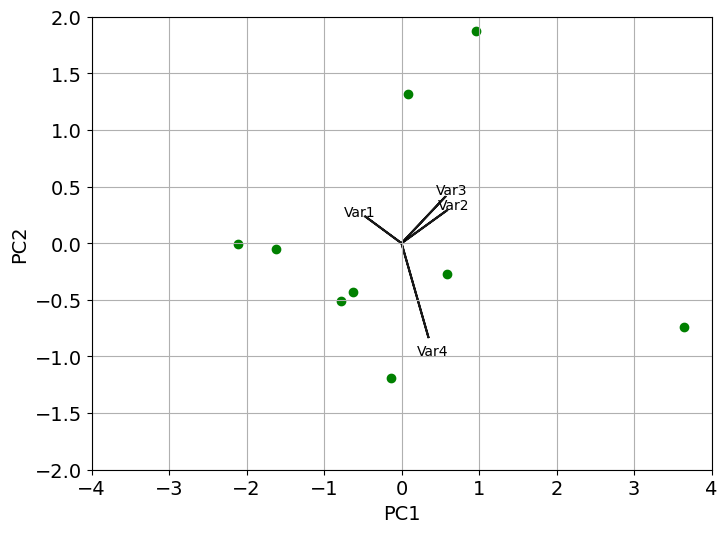

[-------------------------------- [Exercise 10] --------------------------------]


,Exercise 10,Exercise 10 Total Time,Exercise 10 Times Needed Help,Exercise 10 Number of Errors
0,7,39.0,0.0,0.0
1,7,31.0,0.0,0.0
2,7,46.0,1.0,1.0
3,6,64.0,1.0,1.0
4,7,38.0,0.0,0.0
5,7,83.0,2.0,1.0
6,7,31.0,1.0,1.0
7,7,58.0,0.0,0.0
8,7,78.0,1.0,1.0


Correlations:
Kendall Correlation


,Exercise 10,Exercise 10 Total Time,Exercise 10 Times Needed Help,Exercise 10 Number of Errors
Exercise 10,1.000000,-0.239046,-0.216506,-0.316228
Exercise 10 Total Time,-0.239046,1.000000,0.517549,0.415761
Exercise 10 Times Needed Help,-0.216506,0.517549,1.000000,0.912871
Exercise 10 Number of Errors,-0.316228,0.415761,0.912871,1.000000


,Exercise 10,Exercise 10 Total Time,Exercise 10 Times Needed Help,Exercise 10 Number of Errors
Exercise 10,1.000000,0.436661,0.524518,0.371093
Exercise 10 Total Time,0.436661,1.000000,0.081209,0.176098
Exercise 10 Times Needed Help,0.524518,0.081209,1.000000,0.007290
Exercise 10 Number of Errors,0.371093,0.176098,0.007290,1.000000


---- Question Exercise 10 ----
Population Standard Deviation:
0.3142696805273545
Confidence Interval (95%):
(6.632666207218515, 7.145111570559264)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.390, p=0.000
Sample does not look Gaussian (reject H0)


---- Question Exercise 10 Total Time ----
Population Standard Deviation:
18.55921454276674
Confidence Interval (95%):
(36.868754402702876, 67.13124559729712)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.900, p=0.250
Sample looks Gaussian (fail to reject H0)


---- Question Exercise 10 Times Needed Help ----
Population Standard Deviation:
0.6666666666666666
Confidence Interval (95%):
(0.12313627955789486, 1.2101970537754383)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.805, p=0.024
Sample does not look Gaussian (reject H0)


---- Question Exercise 10 Number of Errors ----
Population Standard Deviation:
0.4969039949999533
Confidence Interval (95%):
(0.1504319244182259, 0.9606791866928852)
Normality Tests:
Shapiro-Wilk Test
Statistics=

,Exercise 10,Exercise 10 Total Time,Exercise 10 Times Needed Help,Exercise 10 Number of Errors
0,0.267127,0.494756,0.592372,0.577023
1,0.955125,0.122582,0.260505,0.069627
2,0.012359,0.836871,0.213837,0.503753
3,0.127386,0.199592,0.731783,0.639085


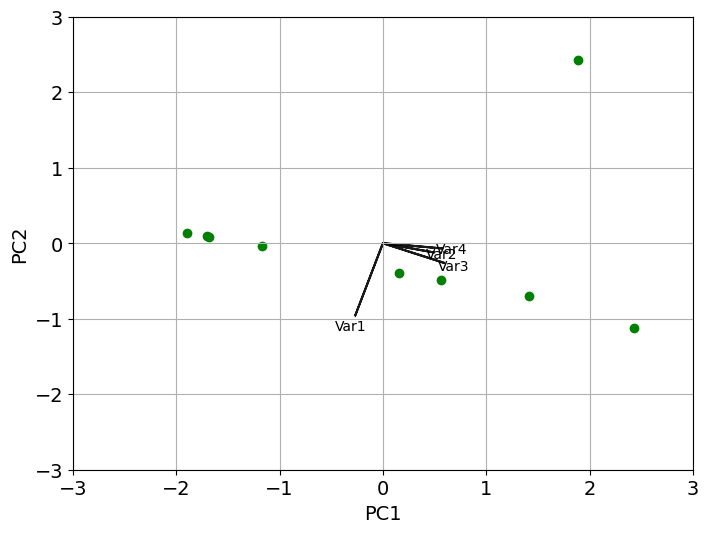

[-------------------------------- [Exercise 11] --------------------------------]


,Exercise 11,Exercise 11 Total Time,Exercise 11 Times Needed Help,Exercise 11 Number of Errors
0,7,11.0,0.0,0.0
1,7,20.0,0.0,0.0
2,7,30.0,1.0,1.0
3,7,25.0,0.0,0.0
4,7,24.0,0.0,0.0
5,6,32.0,1.0,1.0
6,7,25.0,0.0,0.0
7,7,32.0,1.0,0.0
8,7,34.0,0.0,0.0


Correlations:
Kendall Correlation


,Exercise 11,Exercise 11 Total Time,Exercise 11 Times Needed Help,Exercise 11 Number of Errors
Exercise 11,1.000000,-0.303170,-0.500000,-0.661438
Exercise 11 Total Time,-0.303170,1.000000,0.485071,0.320844
Exercise 11 Times Needed Help,-0.500000,0.485071,1.000000,0.755929
Exercise 11 Number of Errors,-0.661438,0.320844,0.755929,1.000000


,Exercise 11,Exercise 11 Total Time,Exercise 11 Times Needed Help,Exercise 11 Number of Errors
Exercise 11,1.000000,0.328858,0.157299,0.061369
Exercise 11 Total Time,0.328858,1.000000,0.118225,0.301444
Exercise 11 Times Needed Help,0.157299,0.118225,1.000000,0.032509
Exercise 11 Number of Errors,0.061369,0.301444,0.032509,1.000000


---- Question Exercise 11 ----
Population Standard Deviation:
0.3142696805273545
Confidence Interval (95%):
(6.632666207218515, 7.145111570559264)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.390, p=0.000
Sample does not look Gaussian (reject H0)


---- Question Exercise 11 Total Time ----
Population Standard Deviation:
6.822258414670556
Confidence Interval (95%):
(20.326731753265946, 31.451046024511832)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.907, p=0.295
Sample looks Gaussian (fail to reject H0)


---- Question Exercise 11 Times Needed Help ----
Population Standard Deviation:
0.47140452079103173
Confidence Interval (95%):
(-0.051000689172228386, 0.7176673558388951)
Normality Tests:
Shapiro-Wilk Test
Statistics=0.617, p=0.000
Sample does not look Gaussian (reject H0)


---- Question Exercise 11 Number of Errors ----
Population Standard Deviation:
0.41573970964154905
Confidence Interval (95%):
(-0.1167285257547171, 0.5611729701991615)
Normality Tests:
Shapiro-Wilk Test
Stati

,Exercise 11,Exercise 11 Total Time,Exercise 11 Times Needed Help,Exercise 11 Number of Errors
0,0.473513,0.417686,0.546642,0.550006
1,0.534111,0.783763,0.146534,0.281015
2,0.649331,0.417655,0.532495,0.346962
3,0.262449,0.191883,0.629412,0.705792


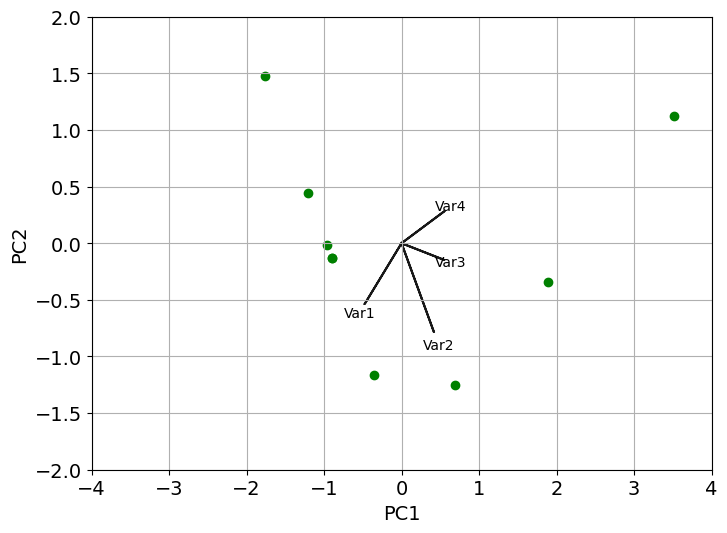

In [ ]:
for i in range(1,12):
    print('[-------------------------------- [Exercise '+str(i)+'] --------------------------------]')
    data_exercise = data_exercises_seq.filter(regex='Exercise ('+str(i)+'$|'+str(i)+' [A-z]+)').drop(columns='Exercise '+str(i)+' Time First Needed Help').dropna()
    display(data_exercise)
    
    print('Correlations:')
    calculate_correlation(data_exercise)
    
    for column in data_exercise:
        print('---- Question', column,'----')
        print('Population Standard Deviation:')
        print(data_exercise[column].std(ddof=0))
        print('Confidence Interval (95%):')
        print(confidence_interval_t(data_exercise[column]))
        print('Normality Tests:')
        normality_tests(data_exercise[column])
        print('\n')
    
    data_exercise_scaled = StandardScaler().fit_transform(data_exercise)
    pca = PCA()
    principalComponents = pca.fit_transform(data_exercise_scaled)
    principalDf = pd.DataFrame(data=principalComponents[:,0:2], columns=['principal component 1', 'principal component 2'])
    print('Explained Variance Ratio:',pca.explained_variance_ratio_)
    print('Components:')
    display(pd.DataFrame(abs(pca.components_), columns=data_exercise.columns))
    
    biplot(principalComponents[:,0:2], np.transpose(pca.components_[0:2, :]), None)
    plt.show()

## General Analysis

In [ ]:
data_full = data['Full'].drop(columns=[
    'Participant',
    'Timestamp',
    'Gender',
    'Education',
    'Education Area',
    'Devices Owned',
    'Experience with Programming Languages',
    'Additional Feedback',
    'Contact'
]).dropna(axis='columns')

data_full['Number of Devices Owned'] = num_devices_owned
data_full['Number of Programming Languages'] = num_programming_languages

data_full = data_full[[
    'Age',
    'Number of Devices Owned',
    'Usage of Multiple Devices',
    'Years of Programming Experience',
    'Programming Experience (Self Assessment)',
    'JavaScript Experience (Self Assessment)',
    'Number of Programming Languages',
    'DS1',
    'DS2',
    'DS3',
    'DS4',
    'DS5',
    'DS6',
    'DS7',
    'DS8', 
    'ULI1', 
    'ULI2', 
    'SDS1', 
    'SDS2',
    'SDS3',
    'SDS4',
    'SDS5',
    'SDS6',
    'NPS'
]]

data_full

,Age,Number of Devices Owned,Usage of Multiple Devices,Years of Programming Experience,Programming Experience (Self Assessment),JavaScript Experience (Self Assessment),Number of Programming Languages,DS1,DS2,DS3,...,DS8,ULI1,ULI2,SDS1,SDS2,SDS3,SDS4,SDS5,SDS6,NPS
0,52,3,7,30,6,6,9,7,7,7,...,7,7,7,7,5,7,7,7,7,9
1,23,2,5,5,6,6,7,7,6,6,...,5,4,6,5,6,6,7,7,7,8
2,24,6,6,6,4,4,4,5,7,6,...,7,6,6,7,2,6,3,6,2,9
3,22,3,3,5,6,5,5,7,6,6,...,7,7,7,7,6,7,6,7,7,9
4,22,3,6,7,5,5,9,6,6,6,...,6,7,6,7,6,7,6,6,6,8
5,24,5,5,5,4,4,4,7,6,6,...,6,6,7,7,7,7,7,7,5,7
6,35,7,7,20,7,7,6,7,6,7,...,7,6,7,7,7,7,7,7,7,10
7,25,5,5,6,5,5,6,7,7,7,...,6,6,7,7,6,6,6,6,6,10
8,29,5,7,4,3,3,6,7,6,6,...,7,7,5,7,5,6,5,5,5,10
9,25,4,6,6,5,5,7,6,7,6,...,6,7,6,7,4,7,4,6,6,9


### General Correlation

In [ ]:
general_correlations = calculate_correlation(data_full);

Kendall Correlation


,Age,Number of Devices Owned,Usage of Multiple Devices,Years of Programming Experience,Programming Experience (Self Assessment),JavaScript Experience (Self Assessment),Number of Programming Languages,DS1,DS2,DS3,...,DS8,ULI1,ULI2,SDS1,SDS2,SDS3,SDS4,SDS5,SDS6,NPS
Age,1.000000,0.127401,0.496924,0.571446,0.300912,0.214753,0.219340,0.489517,0.102337,0.249447,...,0.115847,0.097721,0.028650,0.289587,-0.011078,0.173018,0.027452,0.117733,0.050002,0.126278
Number of Devices Owned,0.127401,1.000000,0.153446,-0.044660,-0.137727,-0.065090,-0.056120,-0.119234,0.329914,0.329914,...,0.219687,0.172958,0.277082,0.410204,0.226190,0.132803,0.023600,0.042172,-0.035821,0.294997
Usage of Multiple Devices,0.496924,0.153446,1.000000,0.454760,0.339610,0.225761,0.387717,0.216970,0.120486,-0.028350,...,0.302044,0.114652,-0.101588,-0.058343,-0.012276,-0.034235,0.036503,0.124245,0.080031,0.042586
Years of Programming Experience,0.571446,-0.044660,0.454760,1.000000,0.572835,0.388469,0.326320,0.256540,0.167599,0.122476,...,0.041207,-0.127451,-0.057748,0.039798,-0.044660,0.087186,0.000000,0.005650,0.044794,-0.132800
Programming Experience (Self Assessment),0.300912,-0.137727,0.339610,0.572835,1.000000,0.702431,0.474236,0.282237,-0.041487,-0.034572,...,-0.051568,-0.223710,0.043360,-0.170759,0.131739,0.100201,0.166190,0.200004,0.312314,-0.166190
JavaScript Experience (Self Assessment),0.214753,-0.065090,0.225761,0.388469,0.702431,1.000000,0.546727,0.202200,0.061494,0.095657,...,-0.203832,-0.110531,0.336658,-0.028123,0.272194,0.244236,0.363638,0.389284,0.445121,0.011730
Number of Programming Languages,0.219340,-0.056120,0.387717,0.326320,0.474236,0.546727,1.000000,0.119028,0.220324,-0.012960,...,-0.144986,-0.069886,0.000000,-0.013336,0.123463,0.050083,0.178000,0.124960,0.281437,-0.050063
DS1,0.489517,-0.119234,0.216970,0.256540,0.282237,0.202200,0.119028,1.000000,-0.056692,0.388744,...,0.094916,-0.021836,0.210405,0.183340,0.413814,0.211254,0.424072,0.376237,0.295460,0.076472
DS2,0.102337,0.329914,0.120486,0.167599,-0.041487,0.061494,0.220324,-0.056692,1.000000,0.396825,...,0.050735,0.028531,0.213298,0.244998,0.034366,-0.007667,0.143066,0.132174,0.165450,0.258881
DS3,0.249447,0.329914,-0.028350,0.122476,-0.034572,0.095657,-0.012960,0.388744,0.396825,1.000000,...,0.295952,0.156919,0.447925,0.449163,0.405520,0.398705,0.395134,0.285218,0.420520,0.374696


,Age,Number of Devices Owned,Usage of Multiple Devices,Years of Programming Experience,Programming Experience (Self Assessment),JavaScript Experience (Self Assessment),Number of Programming Languages,DS1,DS2,DS3,DS4,DS5,DS6,DS7,DS8,ULI1,ULI2,SDS1,SDS2,SDS3,SDS4,SDS5,SDS6,NPS
Age,1.000000,0.465125,0.005026,0.000689,0.087220,0.218526,0.193931,0.007871,0.583308,0.177773,0.254744,0.229864,0.090901,0.630832,0.540289,0.584759,0.872633,0.125717,0.949640,0.348895,0.874914,0.503599,0.775496,0.469569
Number of Devices Owned,0.465125,1.000000,0.406310,0.799145,0.452991,0.720661,0.749851,0.535145,0.090265,0.087726,0.712407,0.366847,0.669906,0.971806,0.266055,0.353931,0.137261,0.037772,0.216345,0.490928,0.896760,0.818343,0.844703,0.105277
Usage of Multiple Devices,0.005026,0.406310,1.000000,0.010734,0.068518,0.222108,0.030090,0.266710,0.542636,0.885182,0.276416,0.786098,0.691692,0.389315,0.132385,0.545272,0.591748,0.771246,0.947337,0.861266,0.843375,0.505339,0.666602,0.817937
Years of Programming Experience,0.000689,0.799145,0.010734,1.000000,0.001215,0.026974,0.054768,0.166395,0.372046,0.510881,0.344638,0.435401,0.189188,0.302431,0.828655,0.478814,0.748132,0.834381,0.800254,0.639051,1.000000,0.974554,0.799580,0.449782
Programming Experience (Self Assessment),0.087220,0.452991,0.068518,0.001215,1.000000,0.000131,0.007566,0.145717,0.832805,0.859251,0.141522,0.617176,0.971748,0.832557,0.795857,0.234694,0.817712,0.391484,0.475414,0.606508,0.365097,0.280304,0.090502,0.365737
JavaScript Experience (Self Assessment),0.218526,0.720661,0.222108,0.026974,0.000131,1.000000,0.001908,0.293262,0.752352,0.620772,0.005724,0.618454,0.525286,0.439852,0.302434,0.553840,0.071170,0.886826,0.137075,0.205522,0.045713,0.034113,0.014996,0.948678
Number of Programming Languages,0.193931,0.749851,0.030090,0.054768,0.007566,0.001908,1.000000,0.522026,0.241979,0.944695,0.124717,0.671930,0.835382,0.704675,0.447693,0.698592,1.000000,0.944306,0.485503,0.788200,0.311791,0.481783,0.111688,0.776332
DS1,0.007871,0.535145,0.266710,0.166395,0.145717,0.293262,0.522026,1.000000,0.783228,0.057198,0.370159,0.179996,0.081678,0.503286,0.649792,0.911867,0.285852,0.380320,0.032367,0.300313,0.027375,0.052567,0.126374,0.691155
DS2,0.583308,0.090265,0.542636,0.372046,0.832805,0.752352,0.241979,0.783228,1.000000,0.055358,0.311854,0.121355,0.444012,0.137486,0.810700,0.886484,0.285527,0.247271,0.860743,0.970402,0.462502,0.501426,0.398123,0.184273
DS3,0.177773,0.087726,0.885182,0.510881,0.859251,0.620772,0.944695,0.057198,0.055358,1.000000,0.259018,0.008930,0.018598,0.007203,0.158949,0.428675,0.023772,0.032478,0.036924,0.051771,0.040810,0.143674,0.030402,0.052742


In [ ]:
with pd.ExcelWriter('out/yanux-skeletron-correlations.xlsx') as writer:  
    data_full.to_excel(writer, sheet_name='Full Data')
    for correlations in general_correlations:
        general_correlations[correlations].to_excel(writer, sheet_name=correlations)